In [3]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.model_selection._split import train_test_split
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn import preprocessing
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, MaxPooling1D, TimeDistributed, GRU
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt


In [4]:
def prepare_sequences(sampl, window_size=100, shift=1): #prepare windows with a given size
    data_set = np.array([])
    labels = np.array([])
    temp_labels = sampl[:, 0]
    sampl = sampl[:, 1:]
    print(sampl.shape)
    for row_index in tqdm(range(0, sampl.shape[0] - window_size, shift)):
        if(row_index == 0):
            data_set = np.array([sampl[row_index : window_size]])
            labels = np.append(labels, temp_labels[row_index])
        else:
            if(temp_labels[row_index] == temp_labels[row_index + window_size]):
                window = sampl[row_index : row_index + window_size]
                data_set = np.append(data_set, [window], axis = 0)
                labels = np.append(labels, temp_labels[row_index])
    return data_set, labels

def load_data(file, nrows = None):
    path = "{}/{}".format("new_data_different_texts", file)
    data = pd.read_csv(path, sep=",", header = None, nrows = nrows) 
#     return np.array(data)
    return pd.DataFrame(data)

In [5]:
# files = os.listdir("{}".format("new_data_different_texts"))
files = os.listdir("{}".format("new_data_different_texts"))
frames = []
number_of_rows = 1500

for file in files: 
    print(file)
    data = load_data(file, number_of_rows)
    frames.append(data)
    
data = pd.concat(frames)
data = np.array(data)
data = data[:, :-1]

001001.txt
002001.txt
003001.txt
004001.txt
005001.txt
006001.txt
007001.txt
008001.txt
009001.txt
010001.txt
011001.txt
012001.txt
013001.txt
014001.txt
015001.txt
016001.txt
017001.txt
018001.txt
019001.txt
020001.txt


In [6]:
print(data)
keys = data[:, 1:3]
for row in range(keys.shape[0]):
    for column in range(keys.shape[1]):
        data[row, column + 1] = data[row, column + 1].lower().replace(" ", "")
        
print(data)

[[1 ' LMenu' ' Tab' ... 187 312 125]
 [1 ' Tab' ' LMenu' ... 172 1139 967]
 [1 ' LMenu' ' Tab' ... 124 218 94]
 ...
 [20 ' T' ' Space' ... 92 405 313]
 [20 ' Space' ' D1' ... 83 185 102]
 [20 ' D1' ' LControlKey' ... 975 10707 9732]]
[[1 'lmenu' 'tab' ... 187 312 125]
 [1 'tab' 'lmenu' ... 172 1139 967]
 [1 'lmenu' 'tab' ... 124 218 94]
 ...
 [20 't' 'space' ... 92 405 313]
 [20 'space' 'd1' ... 83 185 102]
 [20 'd1' 'lcontrolkey' ... 975 10707 9732]]


In [7]:
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((data[:,1], data[:,2]), axis=0).reshape(-1, 1))

first_column = enc.transform(data[:,1].reshape(-1, 1)).toarray()
second_column = enc.transform(data[:,2].reshape(-1, 1)).toarray()


In [8]:
# letters encoding - order: A1A2 B1B2 etc.
encoded_letters = [[]]

for i in range(0, first_column.shape[1]):
    if(i == 0):
      encoded_letters = np.column_stack((first_column[:, i], second_column[:, i]))
    else:
      encoded_letters = np.column_stack((encoded_letters, first_column[:, i], second_column[:, i]))


In [9]:
# normalization - z score
std_scaler = StandardScaler()
encoded_letters_scaled = std_scaler.fit_transform(encoded_letters) 
time_values_scaled = std_scaler.fit_transform(data[:, 3:])

In [10]:
prepared_data = np.column_stack((data[:, 0], encoded_letters_scaled, time_values_scaled))

In [11]:
def prepare_data(data, window_size, random_state = 1):
    data, labels = prepare_sequences(data, window_size = window_size, shift = int(window_size*0.4))
    samples = data
    samples = np.asarray(samples).astype('float32')
    labels = np.asarray(labels).astype('float32')
    (trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples, labels, test_size=0.25, random_state=random_state)
#     (trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples, labels, test_size=0.25, stratify=labels,random_state=1)

    #one hot encoding
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(np.concatenate((trainLabels, testLabels), axis=0).reshape(-1, 1))
    print(trainLabels)
    trainLabels = enc.transform(trainLabels.reshape(-1, 1)).toarray()
    testLabels = enc.transform(testLabels.reshape(-1, 1)).toarray()
    print(trainLabels)
    
    return (trainSamples, testSamples, trainLabels, testLabels, samples, enc)

In [12]:
def print_history_params(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [13]:
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [14]:
def train_model(model, optimizer):
    model.compile(loss='categorical_crossentropy', 
                  optimizer= optimizer,
                  metrics=['accuracy'])
    
    EPOCHS=100
    BATCH=64
    
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    ]
    
    history = model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS
            ,validation_data=(testSamples,testLabels)
            ,callbacks=my_callbacks)
    print_history_params(history);


In [15]:
def get_metrics(model):
    testResults = model.predict(testSamples)
    
    matrix = confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    report = classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    accuracy = accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    cohen_kappa = cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    return (matrix, report, accuracy, cohen_kappa)

def print_metrics(matrix, report, accuracy, cohen_kappa):
    print(matrix)
    print(report)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Cohen's Kappa: {:.2f}".format(cohen_kappa))

In [16]:
from contextlib import redirect_stdout

def save_model(model, test):          
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    
    with open(f"{test}",'a') as f:
        with redirect_stdout(f):
            model.summary()
        
    os.chdir("../..")

In [17]:
def save_results(test, parameters, matrix, report, accuracy, cohen_kappa):
    confusion_matrix = np.array2string(matrix)
        
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    f=open(f"{test}",'a')
    f.write('\nParameters\n\n{}\n\nConfusion Matrix\n\n{}\n\nClassification Report\n\n{}\n\nAccuracy: {}\nCohen Kappa: {}\n'
            .format(parameters, confusion_matrix, report, accuracy, cohen_kappa ))
    f.close()
    os.chdir("../..")


In [18]:
def prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout):
    return 'Window size: {}\nCnn filters: {}\nRnn neurons: {}\nKernel size: {}\nDropout: {}\n'.format(window_size,cnn_filters, rnn_neurons, kernel, dropout)

In [19]:
def build_model1(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Dropout(dropout))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [20]:
def build_model2(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))    
    model.add(Dropout(dropout))

    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [21]:
def build_model3(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [23]:
def build_model4(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [24]:
def build_model5(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Dropout(dropout))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [19]:
def build_model6(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [21]:
def manage_results(model, cnn_filters, rnn_neurons,):
    (matrix, report, accuracy, cohen_kappa) = get_metrics(model)
    print_metrics(matrix, report, accuracy, cohen_kappa)
    save_model(model, test)
    parameters = prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout)
    save_results(test, parameters, matrix, report, accuracy, cohen_kappa)

  3%|██▌                                                                            | 80/2497 [00:00<00:03, 799.80it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 2497/2497 [01:09<00:00, 35.68it/s]


[ 8. 14.  6. ...  9.  2.  9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
******** 1 ********
inputShape: (30, 130)
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_141 (Conv1D)          (None, 29, 16)            4176      
_________________________________________________________________
dropout_162 (Dropout)        (None, 29, 16)            0         
_________________________________________________________________
gru_168 (GRU)                (None, 29, 16)            1632      
_________________________________________________________________
gru_169 (GRU)                (None, 16)                1632      
_________________________________________________________________
dropout_163 (Dropout)        (None, 16)                0         
_______________________

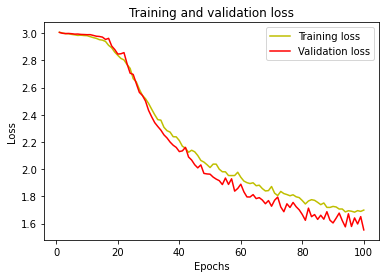

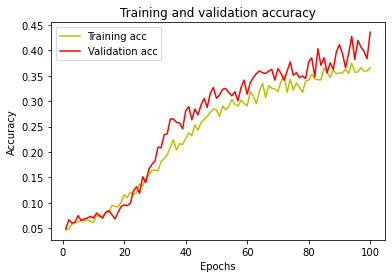

[[17  1  0  0  0  0  0  1  0  1  0  0  0  3  0  0  3  0  0  0]
 [ 5  6  0  0  0  0  0 16  0  2  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  5  0  0  5  0  0  0  0  0  5  4  0  1  0  0  0  7  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  1  0  8  0  0  0  0  0  0  0 22  0  0  0  5  0  0  0]
 [ 0  0  2  0  0  6  2  0  0  0  0  5  0  0  5  0  0  0 11  0]
 [ 0  2  0  0  0  0 27  0  0  0  0  5  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  1 25  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 6  2  0  0  1  0  0  0  1  2  0  0  0  1  0  1 14  1  0  0]
 [10  3  0  0  2  0  2  2  0  9  0  1  0  0  0  0  7  0  0  0]
 [ 0  0  1  0  1  0  2  0  0  6  4  6  7  0  0  6  6  0  0  0]
 [ 0  0  0  0  0  1  6  0  0  0  1 25  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  2 19  0  0  0  2  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
 [ 1  5  0  0  1  0  2  0  0  7  2  1  6  0  0  2  3  0

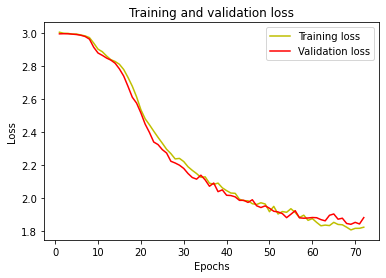

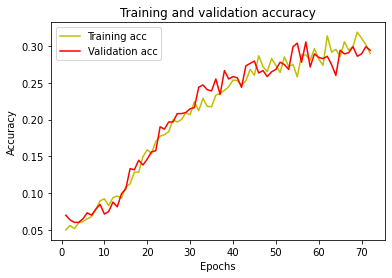

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[12  7  0  1  0  0  1  2  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 9 12  0  0  1  0  0  1  0  4  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0  0 10  1  0 11  0  0  0  1  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  3  0  0  1  1 12  0  0  1  2  9  4  0  0  2  0  0  1  0]
 [ 0  0  1  0  0  5  1  0  0  0  0  3  0  0 15  0  0  0  6  0]
 [ 0  0  0  0  0  1 18  0  0  1  1  9  3  0  0  1  0  0  1  0]
 [11  2  0  2  0  0  0  5  0  1  0  0  0  6  0  0  1  0  0  0]
 [ 6  7  0  0  0  0  0  1  0  7  0  0  1  0  0  6  0  1  0  0]
 [ 6  8  0  0  1  0  3  0  0  5  0  0  0  0  0 13  0  0  0  0]
 [ 0  1  0  0  1  1 14  0  0  0  1  7  7  0  1  4  0  0  2  0]
 [ 0  0  0  0  0  7  1  0  0  0  0 21  1  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  3  5  0  0  0  0 12  5  0  1  1  0  0  1  0]
 [ 1  0  0 21  0  0  0  1  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 1  6  0  0  1  0  8  0  0  5  0  3  1  0  0  4  1  0

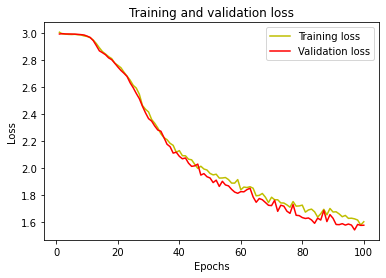

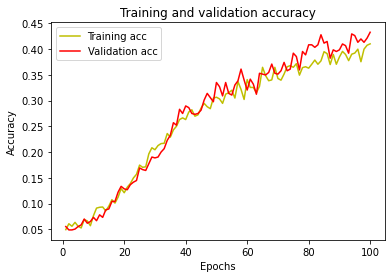

[[10  2  0  3  1  0  1  0  0  2  0  0  0  4  0  0  3  0  0  0]
 [ 0  8  0  2  0  0  0  7  0  3  0  1  0  1  0  5  3  0  0  0]
 [ 0  0  8  0  5  0  0  0  0  0  0  0  6  0  8  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  7  0 13  0  1  0  1  0  2  0  9  0  0  1  1  0  1  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  5  0  0  5  0  0  0 16  0]
 [ 0  0  0  0  0  4 10  0  0  0  1 13  1  0  1  4  1  0  0  0]
 [ 0  3  0  1  0  0  0 23  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 4  0  0  0  7  0  0  0 10  1  2  0  0  0  0  0  3  2  0  0]
 [ 4  5  0  0  0  0  3  1  1 10  0  1  0  0  0  4  7  0  0  0]
 [ 0  0  1  0  4  0  5  0  1  0  5  3 14  0  3  0  2  0  1  0]
 [ 0  0  0  0  0  3  1  0  0  0  0 23  2  0  1  0  0  0  3  0]
 [ 0  0  4  0  5  0  0  0  0  0  4  1  9  0  3  0  0  0  2  0]
 [ 1  0  0 14  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 0  3  0  0  1  0  4  2  0  3  1  0  5  0  0 11  0  0

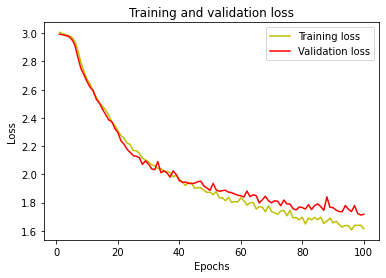

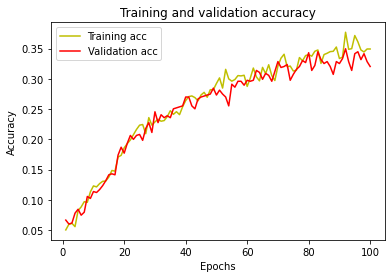

[[14  5  0  0  0  0  0  1  1  3  0  0  0  2  0  0  0  0  0  0]
 [10 12  0  0  0  0  0  0  0  7  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  3  0  0  0  1  6  1  0  5  0  0  0  6  0]
 [ 0  0  0 27  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  1  3  0  0  1  6  0  0  7  9  2  6  0  0  1  0  0  0  0]
 [ 0  0  7  0  0  0  1  0  0  0  0  5  0  0 12  0  0  0  6  0]
 [ 0  0  2  0  0  0 10  0  0  0  9  8  3  0  0  3  0  0  0  0]
 [ 2  2  0  2  0  0  0 14  4  0  0  0  0  4  0  0  0  0  0  0]
 [ 5  3  0  0  0  0  0  5  8  6  1  0  0  0  0  0  0  1  0  0]
 [ 2 14  0  0  0  0  0  0  0 13  5  0  0  0  0  2  0  0  0  0]
 [ 0  1  1  0  2  0  4  0  0  7 11  3  4  0  0  6  0  0  0  0]
 [ 0  0  2  0  0  0 15  0  0  0  0 14  2  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0 11  0  0  2  7  5  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  1  0]
 [ 0  5  0  0  0  0  2  0  0  9  6  3  1  0  0  4  0  0

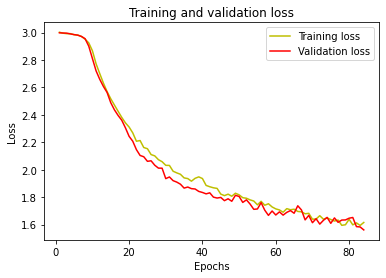

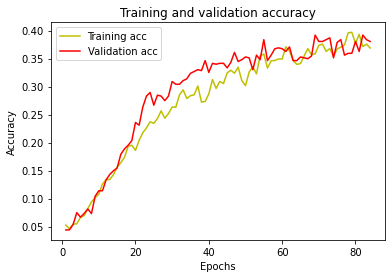

[[ 6  7  0  1  1  0  0  1  3  2  1  0  0  0  0  0  4  0  0  0]
 [ 1 12  0  0  0  0  0  5  0  6  0  0  0  0  0  1  5  0  0  0]
 [ 0  0  2  0  0  4  0  0  0  0  0 10  1  0  1  0  0  0  8  1]
 [ 1  0  0 21  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  1  0  2  0  4  1 11  0  0  0  2  4  0  4]
 [ 0  0  4  0  0 14  0  0  0  0  0  3  0  0  2  0  0  0  6  2]
 [ 0  0  0  0  0  0 17  0  0  1  3 13  0  0  0  1  0  0  0  0]
 [ 3  8  0  0  0  0  0 15  0  1  0  0  0  0  0  1  0  0  0  0]
 [ 3  1  0  0  0  0  1  0 10  0  1  0  1  0  0  0  6  6  0  0]
 [ 2  9  0  0  1  0  3  1  0  8  4  0  1  0  0  2  5  0  0  0]
 [ 0  0  0  0  2  0 10  0  0  5 10  2  5  0  0  1  2  0  0  2]
 [ 0  0  2  0  0  0 14  0  0  0  2 13  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  5  0  0  0  3  4 11  0  0  0  0  0  0  3]
 [ 2  0  0 22  0  0  0  1  1  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 20  0  0  0  0  1]
 [ 0  3  1  0  0  0  6  0  0  6  3  2  2  0  0  2  5  0

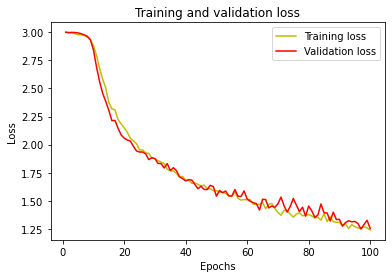

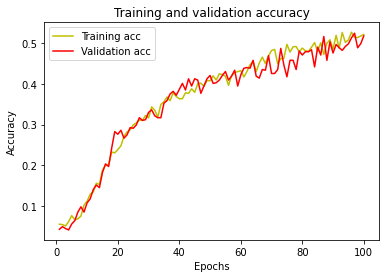

[[11  4  0  2  1  0  0  0  1  0  1  0  0  1  0  0  5  0  0  0]
 [ 1 19  0  0  0  0  0  6  0  3  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 12  0  0  3  2  0  0  0  0  3  4  0  1  0  0  0  2  0]
 [ 0  0  0 28  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  2  0  0  0 16  0  0  0  0  1  0  0]
 [ 0  0  7  0  0  4  2  0  0  0  0  3  0  0  5  0  0  0 10  0]
 [ 0  1  0  0  0  0 31  0  0  0  0  2  0  0  0  1  0  0  0  0]
 [ 1  5  0  1  0  0  1 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0 12  1  1  0  0  2  0  1  4  4  0  0]
 [ 2 11  0  0  0  0  0  0  0 15  3  1  0  0  0  0  4  0  0  0]
 [ 0  0  1  0  2  0  3  0  0  3 15  1  7  0  0  4  3  0  0  0]
 [ 0  0  1  0  0  0 16  0  0  0  1 15  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  5  0  0  0  0  0  6  0 16  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
 [ 0  2  1  0  0  0  2  0  0  8  6  1  4  0  0  3  2  1

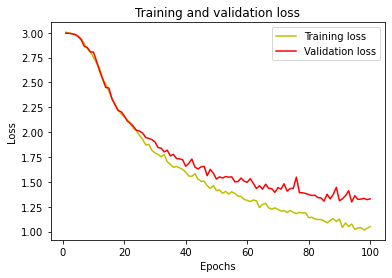

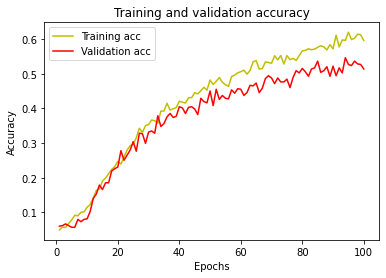

[[16  3  0  0  0  0  0  0  1  3  0  0  0  1  0  0  2  0  0  0]
 [ 0 18  0  0  0  0  0  3  2  6  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 16  0  0  2  0  0  0  0  2  0  4  0  2  0  0  0  0  1]
 [ 0  0  0 25  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  2  0  7  0  1  0  1  2  7  0  7  0  0  0  9  0  0  0]
 [ 0  0  2  0  0  7  5  0  0  0  0  1  0  0  5  0  0  0 10  1]
 [ 0  0  0  0  0  0 23  0  0  0  2  5  0  0  0  5  0  0  0  0]
 [ 0  5  0  1  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  2  0  0  0  0  0  0  5  6  0  0  0  0  0  1  5  2  0  0]
 [ 4  9  0  0  0  0  1  0  2 13  1  0  0  0  0  1  5  0  0  0]
 [ 0  0  2  0  5  0  9  0  0  0 11  2  5  0  0  2  3  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  1 15  0  0  0  5  0  0  1  0]
 [ 0  0  2  0  4  0  4  0  1  0  5  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0]
 [ 0 10  0  0  1  0  3  0  0  3  1  0  1  0  0 11  0  0

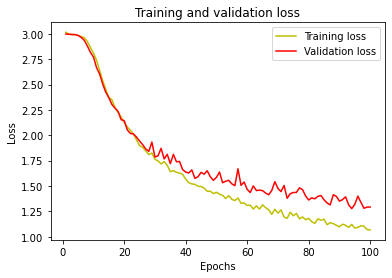

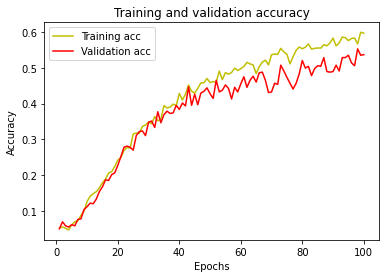

[[16  4  0  0  0  0  0  0  0  0  0  0  0  1  0  0  5  0  0  0]
 [ 5 13  0  0  0  0  2  2  0  1  1  0  0  0  0  2  4  0  0  0]
 [ 0  0 14  0  0  2  0  0  0  0  1  0  4  0  3  0  0  0  0  3]
 [ 0  0  0 27  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  3  0  9  0  0  0  3  0  3  1 14  0  0  0  2  0  0  1]
 [ 0  0  1  0  0 14  0  0  0  0  0  0  0  0  6  0  0  0 10  0]
 [ 0  0  1  0  0  1 14  0  0  0  3 12  0  0  0  4  0  0  0  0]
 [ 0  4  0  0  0  0  0 20  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  0  0  1  0  0  0 16  0  1  0  0  0  0  0  7  1  0  0]
 [ 2 10  0  0  0  0  3  0  0 11  1  0  0  0  0  5  4  0  0  0]
 [ 0  1  1  0  2  1 10  0  0  0 13  3  2  0  2  2  2  0  0  0]
 [ 0  0  0  0  0  1 11  0  0  0  0 17  3  0  0  0  0  0  1  0]
 [ 0  0  4  0  2  1  0  0  0  0  2  3 15  0  0  1  0  0  0  0]
 [ 1  0  0  9  0  0  0  0  1  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 0  1  0  0  0  0  8  0  0  6  4  1  2  0  0  4  4  0

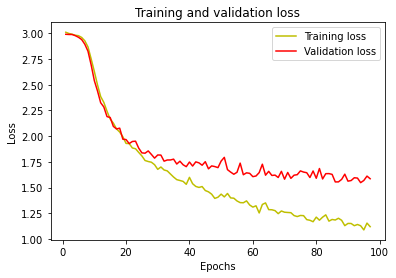

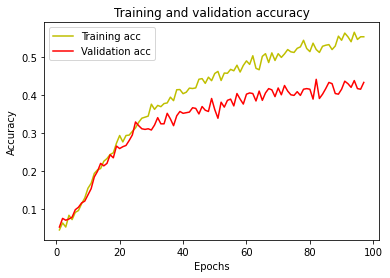

[[16  3  0  0  0  0  0  3  0  3  0  0  0  0  0  1  0  0  0  0]
 [ 2 18  0  0  0  0  1  4  1  3  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 19  0  0  1  0  0  0  0  1  0  0  0  3  1  0  0  2  0]
 [ 0  0  0 17  0  0  0  2  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  1  0  0 14  2  1  0  2  5  0  4  5  0  0  0  0  0  0  2]
 [ 0  0  6  0  0  7  0  0  0  0  0  5  0  0 10  0  0  0  3  0]
 [ 0  0  1  0  0  0 13  0  0  2  4 13  0  0  0  2  0  0  0  0]
 [ 2  2  0  0  0  0  0 16  1  0  0  0  0  6  0  0  1  0  0  0]
 [ 0  7  0  0  3  0  0  2 14  0  1  0  0  0  0  0  0  2  0  0]
 [ 2  3  0  0  1  0  0  0  0 22  4  0  0  0  0  2  2  0  0  0]
 [ 0  0  1  0  0  0  9  0  0  3 10  9  4  0  0  2  1  0  0  0]
 [ 0  0  0  0  1  3 15  0  0  0  2  9  3  0  0  0  0  0  0  0]
 [ 0  1  0  0  3  1  8  0  0  1  2  9  2  0  0  1  0  0  0  0]
 [ 0  0  0 10  0  0  0  3  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  1  0]
 [ 1  2  0  0  3  0  2  0  0 10  4  1  1  0  0  5  1  0

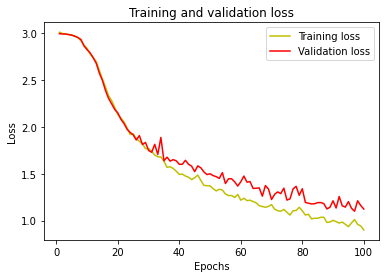

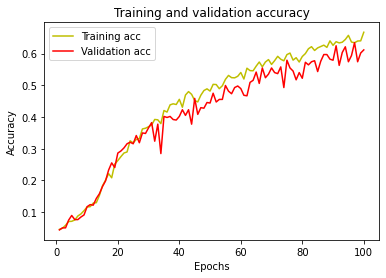

[[14  6  0  0  0  0  0  0  0  2  0  0  0  0  0  0  4  0  0  0]
 [ 2 25  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  1  0  0  0  0  1  0  5  0  0  0  0  0  2  1]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  2  0 15  0  0  0  2  0  2  0 10  0  0  2  1  1  0  1]
 [ 0  0  0  0  0 17  1  0  0  0  1  0  1  0  1  0  0  0 10  0]
 [ 0  0  0  0  0  0 33  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  6  0  1  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  9  0  0  0  1  0  0  5  8  2  0  0]
 [ 1 15  0  0  0  0  0  0  0 16  1  0  0  0  0  2  1  0  0  0]
 [ 0  0  0  0  0  1  9  0  0  1 20  2  3  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  6  1  0  0  1 23  0  0  0  0  0  0  2  0]
 [ 0  0  5  0  1  0  2  0  0  0  5  0 14  0  0  1  0  0  0  0]
 [ 4  0  0  3  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  1  0]
 [ 0  2  1  0  0  0  1  0  0 10  3  1  4  0  0  7  1  0

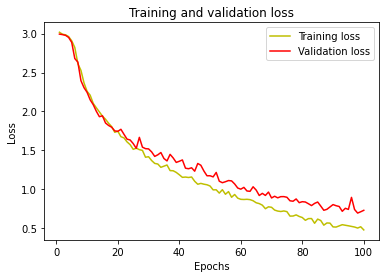

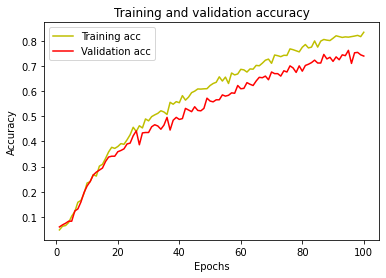

[[15  4  0  1  1  0  0  0  0  1  0  0  0  1  0  0  2  1  0  0]
 [ 3 23  0  0  0  0  0  0  0  1  0  0  0  0  0  0  3  0  0  0]
 [ 0  0 24  0  0  1  0  0  0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  4  0  0  0  4  0  0  0  0  1  0  1]
 [ 0  0  1  0  0 23  0  0  0  0  0  1  2  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0 34  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  1  0  2  0  0  0 21  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  3  0  0  0 21  1  0  0  0  0  0  2  0  2  0  0]
 [ 2  1  0  0  0  0  0  0  0 25  0  0  0  0  0  1  7  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  1 24  1  6  0  0  2  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 31  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  1  1 25  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  1  2 11  0  2  0  0  0  9  0  3

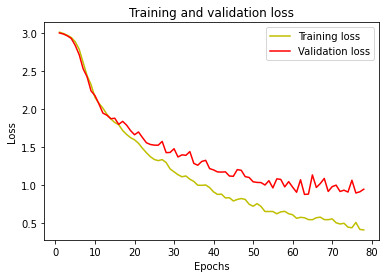

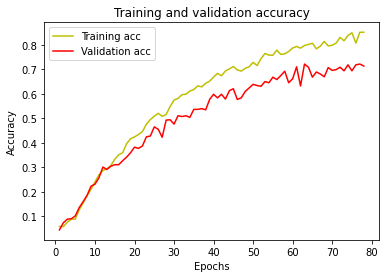

[[17  2  0  1  0  0  0  0  0  1  1  0  0  2  0  0  2  0  0  0]
 [ 3 23  0  0  0  0  1  0  0  1  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  0  0  0  2  0  2  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  2  0 18  0  0  0  3  0  2  0  8  0  0  0  1  0  0  2]
 [ 0  0  3  0  0 24  1  0  0  0  0  0  0  0  1  0  0  0  2  0]
 [ 0  0  0  0  0  0 34  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  1  0  3  0  0  0 21  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  0  0  1  5  0  0  0 17  1  0  0  0  0  0  0  2  1  0  0]
 [ 4  2  0  0  0  0  0  1  0 20  1  2  0  0  0  3  2  1  0  0]
 [ 0  0  2  0  1  0  2  0  0  0 23  0  9  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 28  4  0  0  0  0  0  0  0]
 [ 0  0  5  0  2  0  1  0  0  0  1  1 17  0  0  0  0  0  0  1]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 21  0  0  0  0  0]
 [ 0  0  1  0  0  2  0  0  0  4  3  2  2  0  0 10  4  0

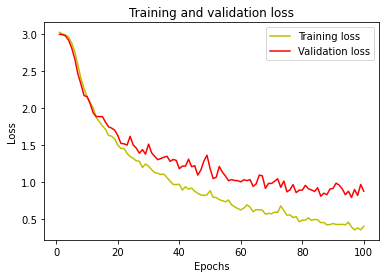

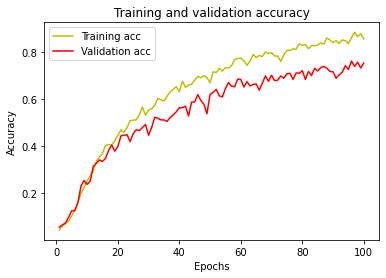

[[14  3  0  0  0  0  0  0  1  2  0  0  0  3  0  0  3  0  0  0]
 [ 0 23  0  0  0  0  1  2  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  3  0 19  0  0  0  0  0  1  0 11  0  0  0  2  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  2  0  1  0  0  0 22  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 2  0  0  0  2  0  0  0 21  0  1  0  0  0  0  1  1  1  0  0]
 [ 3  4  0  0  0  0  4  0  0 23  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  1  4  0  0  2 27  1  2  0  0  0  1  0  0  0]
 [ 0  0  1  0  0  0  3  0  0  0  1 28  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  3  0  0  0  0  5  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  4  1  3  1  0  0 20  0  0

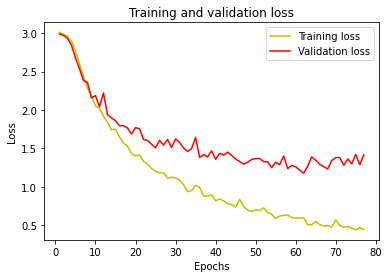

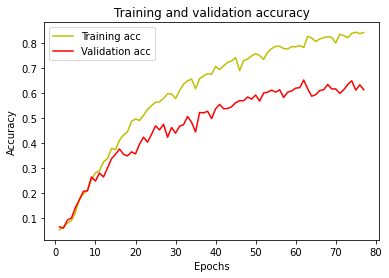

[[17  2  0  0  0  0  0  1  0  3  0  0  0  2  0  0  1  0  0  0]
 [ 6 17  0  0  0  0  1  1  0  4  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 13  0  0  1  0  0  0  0  3  0  5  0  3  0  0  0  1  1]
 [ 0  0  0 23  0  0  0  1  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  2  4  0  6  0  0  1  4  0  1  1]
 [ 0  0  0  0  0 24  3  0  0  0  0  3  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  2 32  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  2  0  1  0  0  0 22  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 5  3  0  0  3  0  0  0 12  1  0  0  0  1  0  0  4  0  0  0]
 [ 4  6  0  0  0  0  3  0  0 18  1  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  3  7  0  0  1 19  1  4  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  1 24  1  0  0  2  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  8  4 13  0  0  0  1  0  1  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 14  0  0  0  8  0]
 [ 0  5  0  0  0  0  1  0  0  1  3  3  2  0  0 13  1  0

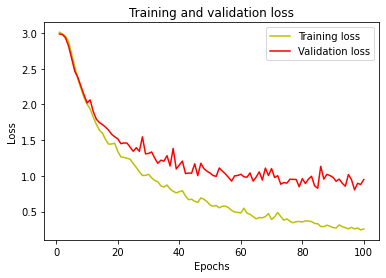

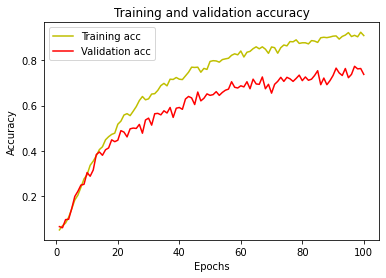

[[14  6  0  0  0  0  0  0  1  0  0  0  0  0  0  1  3  1  0  0]
 [ 0 24  0  0  0  0  1  0  0  1  0  0  0  0  0  1  3  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  0  2  1  0  0  0  0  0  0  0  1]
 [ 0  0  0 28  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  1  0  3  1  8  0  1  0  3  0  0  1]
 [ 0  0  2  0  0 22  1  0  0  0  0  2  0  0  2  0  0  0  2  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  9  0  1  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 21  3  0  0  0  0  0  0  0  4  0  0]
 [ 2  4  0  0  0  0  0  0  0 22  0  1  0  0  0  1  6  0  0  0]
 [ 0  0  1  0  3  1  3  0  0  0 24  3  2  0  0  0  2  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  2 29  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  1  2 21  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  1  1]
 [ 0  3  1  0  0  0  0  0  0  0  0  2  1  0  0 19  2  2

In [31]:
window_size = 30
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test1c_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model4(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model5(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

  4%|██▉                                                                            | 70/1872 [00:00<00:02, 687.19it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:48<00:00, 38.22it/s]


[13.  9.  3. ... 13.  3. 12.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
******** 1 ********
inputShape: (40, 130)
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_168 (Conv1D)          (None, 39, 16)            4176      
_________________________________________________________________
dropout_192 (Dropout)        (None, 39, 16)            0         
_________________________________________________________________
gru_198 (GRU)                (None, 39, 16)            1632      
_________________________________________________________________
gru_199 (GRU)                (None, 16)                1632      
_________________________________________________________________
dropout_193 (Dropout)        (None, 16)                0         
_______________________

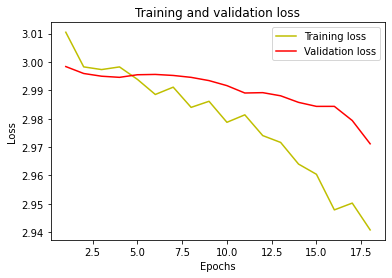

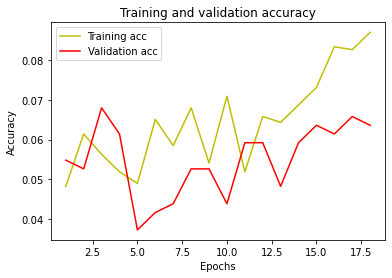

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0  0  0  0  0  7  0  0  0  0  0  0  0 12  0  0  1  3  0  1]
 [ 0  0  1  0  0 11  0  0  0  2  0  0  0  6  0  2  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  1  0  0  0  0  2  0  2  1  1  0  0]
 [ 0  0  1  1  0  7  0  0  0  2  1  0  0 10  0  2  0  1  0  1]
 [ 0  0  1  0  0 15  0  0  1  0  0  0  0  4  0  1  0  1  1  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0 11  0  0  1  2  0  0  0  8  0  0  1  1  0  1]
 [ 0  0  1  0  0 13  0  0  0  2  0  0  0  6  0  0  1  2  0  0]
 [ 0  0  0  0  0 12  0  0  1  2  0  0  0  6  0  0  0  0  0  1]
 [ 0  1  0  0  0 10  0  0  1  0  0  0  0  4  0  1  1  0  0  0]
 [ 0  0  0  0  0 10  0  0  1  1  0  0  0  6  0  0  0  2  2  0]
 [ 0  0  0  0  0 13  0  0  1  0  0  0  0  6  0  0  1  3  0  0]
 [ 0  2  0  0  0 16  1  0  0  0  0  0  0  1  0  1  2  0  0  0]
 [ 0  1  0  1  0  6  0  0  0  0  0  0  0  8  0  0  2  2  0  1]
 [ 0  0  1  0  0 13  0  0  1  2  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  1  0  0 13  0  0  1  3  0  0  0  6  0  2  0  1

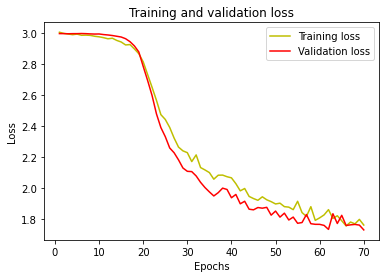

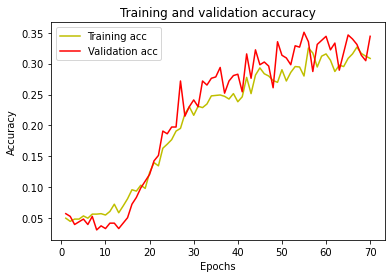

[[10  6  0  0  0  0  0  0  3  0  0  0  0  5  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  3  4  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  4  0  0  1  2  0  0  0  1  8  3  0  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  1  0  0  3  8  1  3  0  0  3  2  0  0  0]
 [ 0  0  2  0  0  3  1  0  0  0  0  4  0  0  2  0  0  0  1  0]
 [ 0  0  0  0  0  0  6  0  0  0 11  3  6  0  0  0  0  0  0  0]
 [ 9  5  0  0  0  0  0  4  5  0  0  0  0  2  0  0  0  0  0  0]
 [ 2  8  0  0  0  0  0  2  0  2  1  0  0  2  0  1  2  1  0  1]
 [ 0  6  0  0  0  0  0  0  0  6  1  0  0  0  0  3  2  0  0  0]
 [ 0  2  0  0  0  0  1  0  0  3  7  3  2  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  1  3  0  0  0  1 16  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  1  5  8  3  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  1  0  0 17  0  0  0  0  0]
 [ 0  2  0  0  0  0  3  0  0 11  7  0  1  0  0  3  0  0

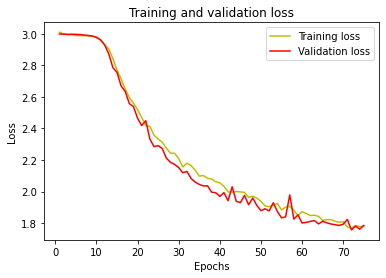

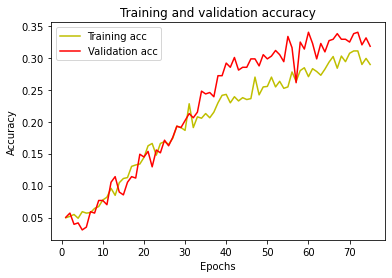

[[ 9 11  0  2  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6 12  0  0  0  0  0  0  0  1  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  3  6  0  0  2  0  0  0  0  0]
 [ 1  0  0  6  0  0  0  2  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  1  0  0  4  0  0  0  0  7  8  2  0  0  0  0  1  0  0  1]
 [ 0  0  2  0  0  3  1  0  0  0  0  4  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0  4  0  0  2 15  4  0  0  0  0  0  0  0  0]
 [13  6  0  0  0  0  0  5  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 11  0  0  1  0  0  2  0  2  0  0  0  0  0  0  4  1  0  1]
 [ 0  3  0  0  0  0  0  0  0 10  0  0  0  0  0  0  5  0  0  0]
 [ 0  1  1  0  6  0  1  0  0  6  5  0  1  0  0  0  1  0  0  0]
 [ 0  0  3  0  0  0  6  0  0  0  7  6  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  5  0  1  0  0  2 11  2  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0]
 [ 0  4  0  0  5  0  0  0  0 11  6  1  0  0  0  0  0  0

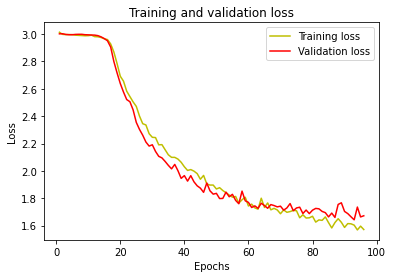

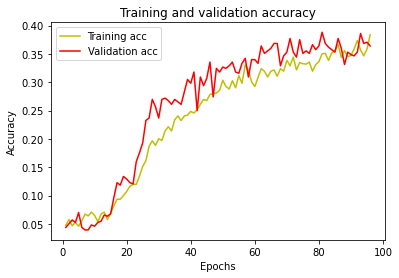

[[ 1  4  0  0  0  0  0 15  1  0  0  0  0  3  0  0  0  0  0  0]
 [ 1 15  0  0  0  0  0  4  0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  2  0  0  9  0  0  0  0  2  3  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  3  4  7  1  0  0  3  1  0  0  1]
 [ 0  0  2  0  0  7  1  0  0  0  1  0  0  0  0  0  0  0  1  1]
 [ 0  0  0  0  1  0  6  0  0  2  6  4  0  0  0  6  1  0  0  0]
 [ 2  0  0  0  0  0  0 21  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  3  3  2  0  0  0  0  0  0  2  2  0  0]
 [ 1  4  0  0  0  0  1  0  1  7  0  0  0  0  0  1  3  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  5  9  4  0  0  0  2  0  0  0  0]
 [ 0  0  1  0  0  2  4  0  0  0  3  9  5  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  1  0  0  0  1  7  7  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 0  5  1  0  0  0  5  0  1  5  3  1  0  0  0  4  2  0

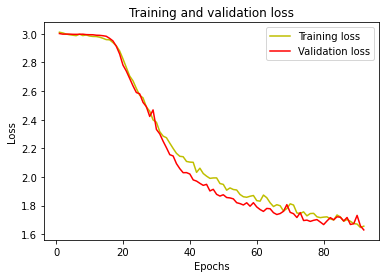

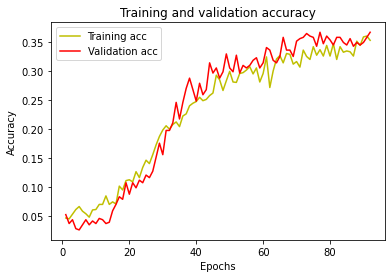

[[ 1  4  0  1  0  0  0 16  0  0  0  0  0  1  0  0  1  0  0  0]
 [ 0 16  0  0  1  0  0  4  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  4  2  0  5  0  0  0  2  3]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  2  0  0 12  0  0  0  0  0  5  0  3  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0  1  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0  0  5 11  7  0  0  1  0  0  0  0]
 [ 0  2  0  1  0  0  0 21  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  1  0  0  6  0  0  1  0  0  0  0  3  0  2  0  0]
 [ 0 13  0  0  2  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  5  1  0  0  0  1  6  3  1  0  0  2  0  0  1  0]
 [ 0  0  0  0  2  3  1  0  0  0  2  9  7  0  0  0  0  0  0  0]
 [ 0  1  0  0  5  1  0  0  0  0  2  5  6  0  1  0  0  0  1  1]
 [ 0  0  0  6  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  1  1]
 [ 0  8  0  0  6  0  0  0  0  1  1  1  6  0  0  4  0  0

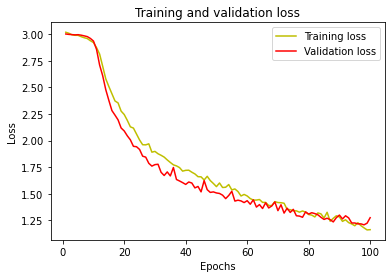

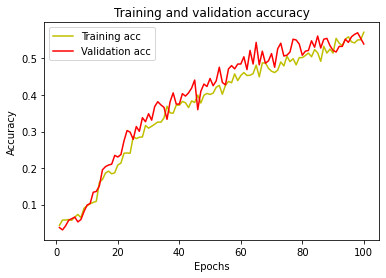

[[10 10  0  0  0  0  0  0  1  0  0  0  0  2  0  0  1  0  0  0]
 [ 3 11  0  0  0  0  0  0  3  4  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 11  0  0  2  1  0  0  0  0  1  4  0  1  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  1  0  0  4  0  4  0  3  1  1  4  2  0  0  2  1  1  0  0]
 [ 0  0  0  0  0  7  0  0  0  0  0  5  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  2  0 13  0  0  2  2  2  2  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0 24  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0 13  4  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  3 13  0  0  0  0  0  2  0  0  0  0]
 [ 0  1  0  0  1  0  5  0  3  1  2  5  1  0  0  0  2  1  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0 20  0  0  0  0  0  0  1  0]
 [ 0  0  3  0  6  0  5  0  0  0  1  1  7  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  3 14  2  2  0  0  0  4  0  1

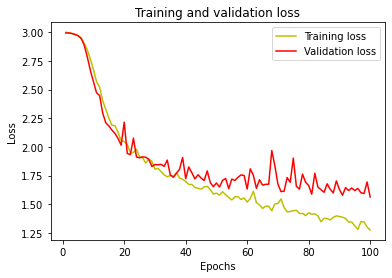

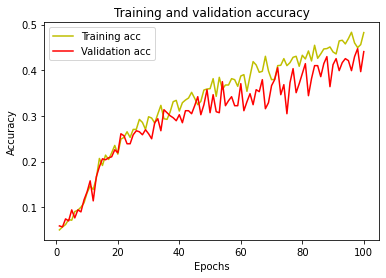

[[11  2  0  0  0  0  0  9  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 8 10  0  0  0  0  0  2  0  1  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  8  0  0  1  1  0  0  0  0  5  3  0  0  0  0  0  2  0]
 [ 0  0  0 22  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  1  0  0  3  5  1  2  0  0  4  0  0  1  1]
 [ 0  0  6  0  0  4  0  0  0  0  0  2  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  8  0  0  1  8  2  4  0  0  2  1  0  0  0]
 [ 3  0  0  0  0  0  0 20  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 2  4  0  0  0  0  0  2  4  6  0  0  0  0  0  2  0  1  0  1]
 [ 0  4  0  0  0  0  0  0  4  7  0  0  0  0  0  1  2  0  0  0]
 [ 0  1  0  0  2  0  3  0  0  4  7  1  1  0  0  2  1  0  0  0]
 [ 0  0  2  0  2  0  4  0  0  0  0  7  9  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  0  2  0  0  0  6  5  4  0  0  2  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 16  0  0  0  3  0]
 [ 0  1  0  0  1  0  3  0  2  8  3  0  0  0  0  9  0  0

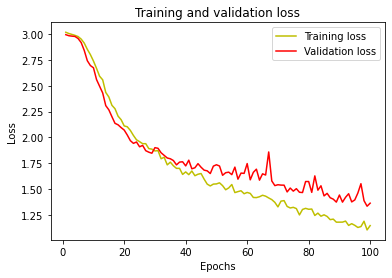

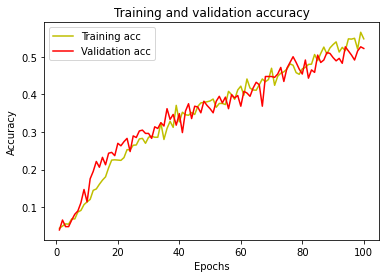

[[17  2  0  0  0  0  0  3  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 4 16  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  6  0  0  2  1  0  0  0  1  2  7  0  0  0  0  0  1  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  1  1  0  0  2  0  0  7  0  2  0  1]
 [ 0  0  3  0  0  7  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  1  1  3  1  0  0  0  1  0  0  0]
 [ 2  0  0  0  0  0  0 21  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3 14  2  0  0  0  0  0  0  0  3  0  0]
 [ 1  4  0  0  0  0  0  1  2  6  0  0  0  0  0  1  3  0  0  0]
 [ 0  2  1  0  0  0  7  0  0  2  3  2  1  0  0  3  1  0  0  0]
 [ 0  0  2  0  0  1  5  0  0  0  1 13  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  7  0  0  2  4  3  4  0  0  2  0  0  0  0]
 [ 1  0  0  1  0  0  0  3  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0  0 15  0  0  0  1  0]
 [ 1  1  0  0  1  0  2  0  3  6  2  0  1  0  0 10  0  0

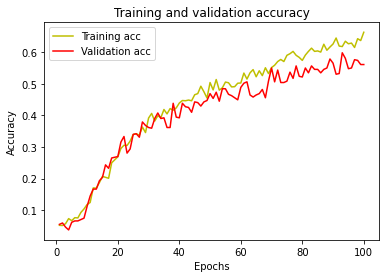

[[15  4  0  0  0  0  0  0  1  0  0  0  0  2  0  0  2  0  0  0]
 [ 2 14  0  0  0  0  0  0  0  3  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  7  0  0  2  1  0  0  0  0  1  6  0  1  1  0  0  1  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  2  3  4  0  0  1  3  3  7  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0 15  0  0  0  3  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  4  0  0  0  0  0  0  1  0  0  0  0]
 [ 1  1  0  0  2  0  0  0  7  1  0  0  0  1  0  3  4  1  0  1]
 [ 0  7  0  0  1  0  0  0  0  9  1  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  1  0  7  0  0  1  8  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  2  5  0  0  0  1 11  0  0  0  0  0  0  2  0]
 [ 0  0  1  0  0  1  5  0  0  0  0  0 14  0  0  0  1  0  1  0]
 [ 2  0  0  1  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  1  0]
 [ 0  0  1  0  3  0  0  0  3  3  1  2  2  0  0 10  2  0

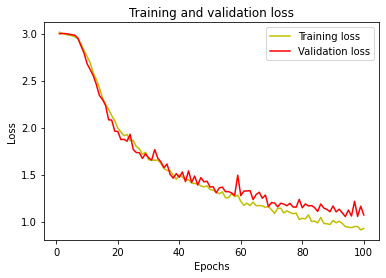

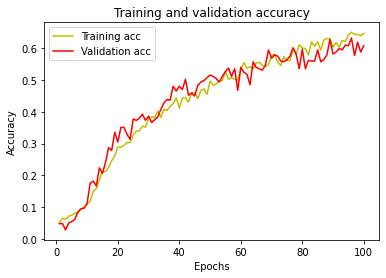

[[19  3  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 3 16  0  0  0  0  0  0  0  2  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  6  0  0  6  1  0  0  0  1  4  1  0  0  0  0  0  1  0]
 [ 0  0  0 22  0  0  0  2  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  3  0  2  0  5  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  5  0  0  0  0  0  3  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0 12  0  0  0  6  6  1  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  2  0  0  0 14  1  0  0  0  0  0  0  1  2  0  0]
 [ 0  6  0  0  0  0  0  0  0 10  0  0  0  0  0  0  2  0  0  0]
 [ 0  1  0  0  0  0  5  0  0  5  7  3  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  2  0  0  0  4  1 15  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  1  0 13  0  0  0  1  0]
 [ 0  2  0  0  0  0  5  0  1 12  1  0  1  0  0  3  2  0

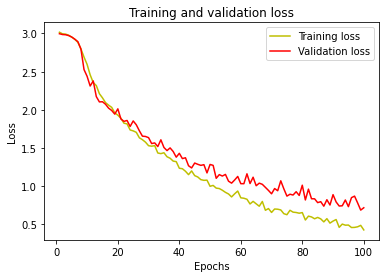

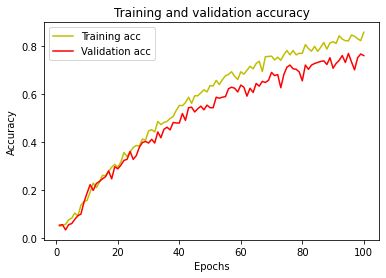

[[17  0  0  1  0  0  0  0  0  0  0  0  0  2  0  0  4  0  0  0]
 [ 1 18  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 14  0  0  0  1  0  0  0  1  0  2  0  0  0  0  0  1  1]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  1  0  2  0  5  0  0  2  0  0  0  1]
 [ 0  0  1  0  0  8  0  0  0  0  0  0  2  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0 24  0  0  0  1  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 23  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 17  2  0  0  0  0  0  0  0  1  0  1]
 [ 1  0  0  0  0  0  0  0  0 16  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  2  9  2  3  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  1  0]
 [ 0  0  2  0  0  0  0  0  0  1  1  0 19  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1  1  4  2  2  1  0  0 14  0  1

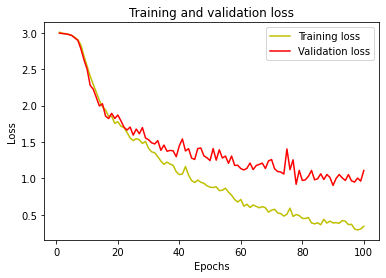

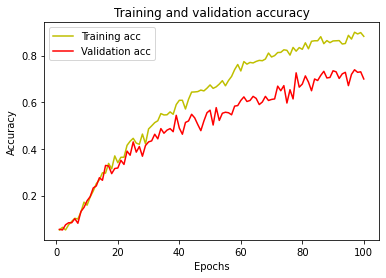

[[17  0  0  1  0  0  0  0  2  0  0  0  0  1  0  0  3  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0 10  0  0  1  0  0  0  0  3  0  6  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  0 17  0  0  0  3  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  7  1  0  0  0  1  2  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 23  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 23  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  2  4  0  0]
 [ 0  2  0  0  0  0  0  0  0 14  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  1  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  1  6  0  0  0  2 14  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  4  0  1  0  0  0  4  1 12  0  0  0  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0 16  0  0  0  1  0]
 [ 0  2  1  0  0  0  0  0  1  4  5  2  0  0  0 11  1  0

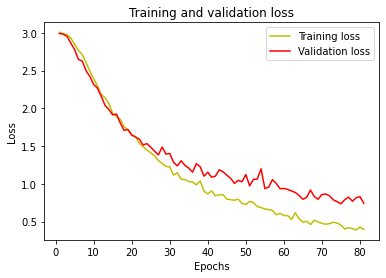

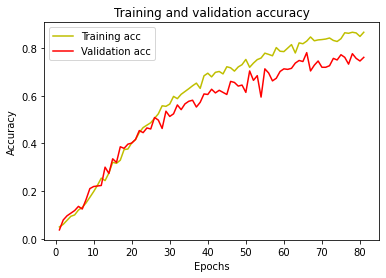

[[20  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  4  1  0  0  0  0  0  2  0  1  0  0  0  1  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  1  1  3  6  0  0  0  0  0  1  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0 23  0  0  2  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 24  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2 16  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0  0 15  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  1  0  1  0  1  3 10  1  3  0  0  1  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  1 19  1  0  0  0  0  0  2  0]
 [ 0  0  1  0  1  0  0  0  0  0  1  0 16  0  0  0  0  0  4  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  3  0  2  1  1  0  0 18  0  0

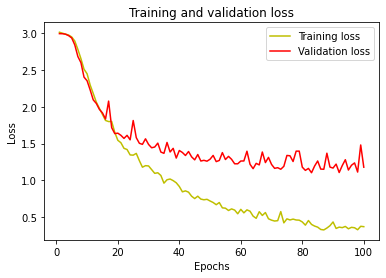

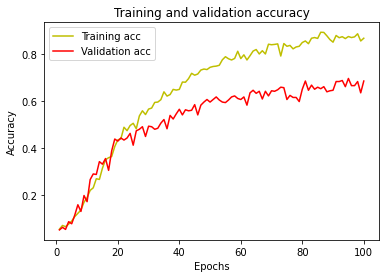

[[16  0  0  0  0  0  0  0  1  2  0  0  0  5  0  0  0  0  0  0]
 [ 1 15  0  0  0  0  0  4  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  3  4  0  0  0  0  0  1  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0 19  1  0  0  2  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  1  0  0  0  0  1  0  0  0  0  0  0  0  1]
 [ 0  1  0  0  0  0 20  0  0  0  0  4  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  4  0  0  1 11  1  0  0  0  2  0  0  0  1  0  1]
 [ 1  1  0  0  0  0  0  0  0 14  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  1  0  0  0  1  2 10  3  0  0  0  1  4  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  1 18  2  0  0  0  0  0  0  0]
 [ 0  0  4  0  1  0  0  0  0  0  4  0 13  0  0  0  1  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  1  0  0  2  0  0  0  0  0  0  0  0 13  0  0  0  4  0]
 [ 0  6  0  0  2  0  4  0  1  2  2  3  0  0  0  7  0  0

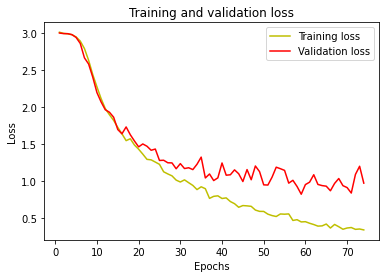

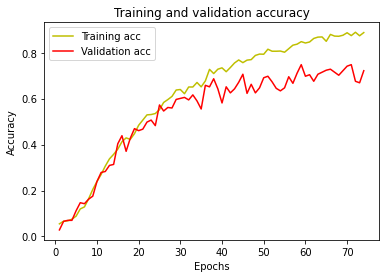

[[16  2  0  1  0  0  0  0  0  0  0  0  0  2  0  0  3  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 11  0  0  1  0  0  0  0  1  2  3  0  0  2  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  2  0 11  0  0  0  4  0  0  0  2  0  0  3  1  1  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 22  0  0  1  3  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0 15  1  0  0  0  0  0  0  0  4  0  0]
 [ 0  3  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 14  2  1  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  1 20  0  0  0  0  0  0  1  0]
 [ 0  0  2  0  1  0  0  0  0  0  5  3 12  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  0  0  0 12  0  0  0  6  0]
 [ 1  0  0  0  0  0  0  1  0  8  1  2  0  0  0 14  0  0

In [32]:
window_size = 40
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test1c_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model4(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model5(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

  4%|███▍                                                                           | 65/1497 [00:00<00:02, 643.57it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 1497/1497 [00:39<00:00, 37.51it/s]


[ 5. 19. 11. ... 16.  4. 15.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
******** 1 ********
inputShape: (50, 130)
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_195 (Conv1D)          (None, 49, 16)            4176      
_________________________________________________________________
dropout_222 (Dropout)        (None, 49, 16)            0         
_________________________________________________________________
gru_228 (GRU)                (None, 49, 16)            1632      
_________________________________________________________________
gru_229 (GRU)                (None, 16)                1632      
_________________________________________________________________
dropout_223 (Dropout)        (None, 16)                0         
______________________

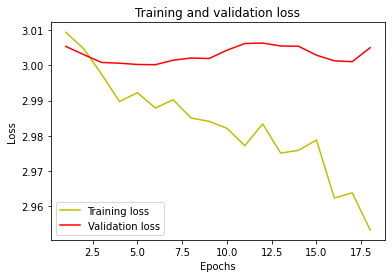

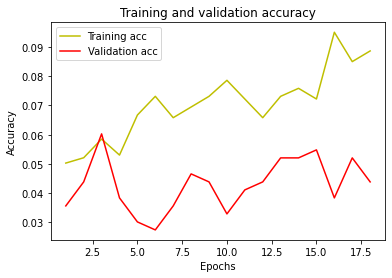

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 1  0  5  0  0  1  0  0  0  0  0  0  1  0  1  0  0  0  8  0]
 [ 0  0  4  0  0  1  0  0  1  0  0  0  2  0  0  0  2  0 15  0]
 [ 0  0  9  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  7  0]
 [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0 10  0]
 [ 0  0  1  1  0  1  0  0  1  1  0  0  1  0  0  0  0  0 10  0]
 [ 0  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 10  0]
 [ 0  0  5  2  0  0  0  0  0  0  0  0  0  0  3  0  0  0 11  0]
 [ 0  0  7  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0 12  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
 [ 0  0  8  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0 11  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0 15  0]
 [ 0  0  3  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0 12  0]
 [ 0  0  8  3  0  0  0  0  0  0  0  0  0  0  1  0  1  0 10  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0 11  0]
 [ 0  0  1  2  0  2  0  0  1  0  0  0  1  0  0  0  0  0

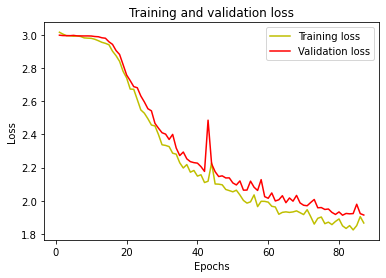

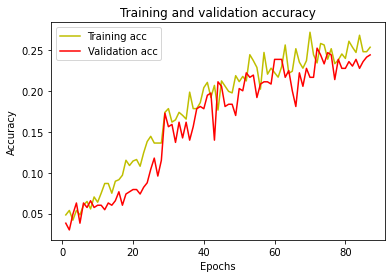

[[10  3  0  0  0  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 4 10  0  0  0  0  0  2  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  2  0  2  0  0  0  0  1  0  0  5  0  0  1  2  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  2  0  0  5  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  6  0  0  0  2  0  0  0  0  0  0  0  6  0  0  0  1  0]
 [ 0  0  1  0  6  0  6  0  0  1  0  0  0  0  0  0  0  0  1  0]
 [ 9  2  0  3  0  0  0  3  0  1  0  0  0  3  0  0  0  0  0  0]
 [ 3  6  0  0  1  0  0  1  0  9  0  0  0  0  0  0  1  0  0  0]
 [ 2  2  0  0  1  0  0  0  0 11  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  2  0  6  0  5  0  0  2  0  0  2  0  0  0  0  3  1  0]
 [ 0  0  5  0  2  0  8  0  0  0  0  0  2  0  0  0  0  0  3  0]
 [ 0  0  0  0  6  0  6  0  0  1  0  0  2  0  0  0  0  2  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  3  0]
 [ 0  4  0  0  4  0  0  0  0 11  0  0  2  0  0  0  0  2

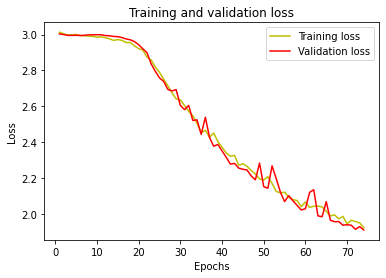

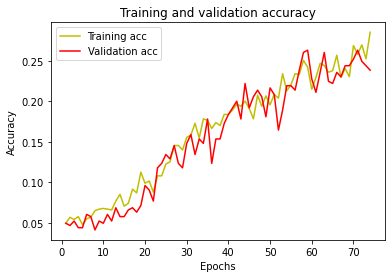

[[ 3  2  0  0  0  0  0  5  0  6  0  0  0  1  0  0  0  0  0  0]
 [ 7  1  0  0  0  0  0  5  1 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  3  0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  2  1  0  0  0  0  0  1  0  7  0  0  0  1  0]
 [ 0  0  0  0  0  1  2  0  0  0  1  0  1  0  6  0  0  0  4  0]
 [ 0  0  0  0  0  2  4  0  0  0  0  0  0  0  1  0  1  0  7  0]
 [ 3  0  0 11  0  0  0  6  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  3  0  1  0  0  0  3  2  5  2  0  0  0  0  0  0  3  1  0]
 [ 3  1  0  0  0  0  1  0  0  8  1  0  0  0  0  0  3  0  0  0]
 [ 0  0  1  0  0  3  3  0  0  0  2  1  2  0  1  0  1  0  7  0]
 [ 0  0  0  0  0  5  2  0  0  0  0  1  1  0  1  0  2  0  8  0]
 [ 0  0  1  0  1  3  0  0  0  0  0  0  0  0 10  0  0  0  2  0]
 [ 0  0  0 18  0  0  0  4  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 2  1  0  0  1  0  3  0  0  4  5  0  0  0  0  0  6  0

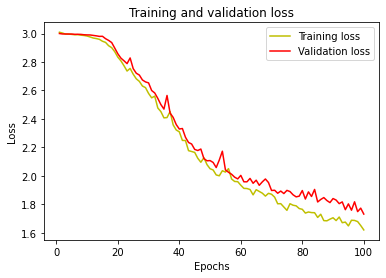

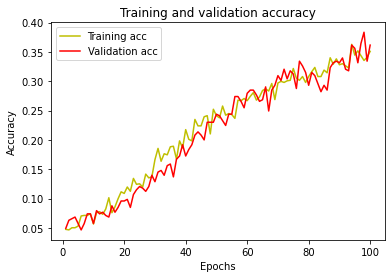

[[14  0  0  0  0  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 7  6  0  0  0  0  0  7  1  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  5  0  0  4  0  0  0  0  0  1  0  0  5  0  0  0  2  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  2  2  0  2  1  2  0  1  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  5  0  0  0  0  0  2  0  0  3  0  0  0  2  0]
 [ 0  0  2  0  0  0  8  0  0  1  3  1  0  0  0  0  0  0  0  0]
 [ 7  0  0  2  0  0  0  7  0  0  0  0  0  3  0  0  2  0  0  0]
 [ 0  2  0  2  1  0  0  3  7  0  0  0  0  2  0  0  1  3  0  0]
 [ 3  0  0  0  0  0  0  0  0  6  0  0  0  0  0  1  7  0  0  0]
 [ 0  0  2  0  2  7  4  0  1  2  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  1  7  0  0  0  4  2  1  0  1  0  0  0  1  0]
 [ 0  0  3  0  1  4  1  0  0  0  2  0  1  0  3  0  0  0  2  0]
 [ 0  0  0 18  0  0  0  4  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  1  0]
 [ 3  0  0  0  5  0  4  0  0  4  1  0  0  0  0  0  6  0

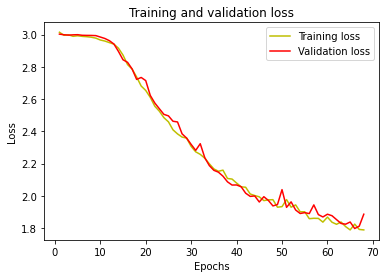

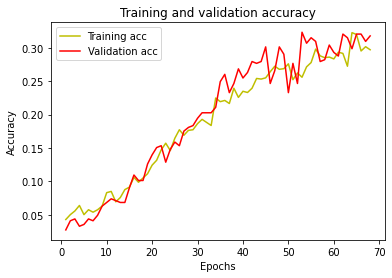

[[ 9  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0 13  0  0  0  0  1  0  0  6  4  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  2  0  0  0  0  4  0  0  7  0  0  0  3  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  5  0  0  0  1  4  0  0  0  0  1  0  4  0]
 [ 0  0  0  0  2  0  1  0  0  0  0  1  2  0  3  0  0  0  6  0]
 [ 0  0  0  0  0  0  8  0  0  1  3  1  2  0  0  0  0  0  0  0]
 [13  4  0  0  0  0  0  2  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 8  4  0  0  0  0  1  0  0  1  1  0  0  1  0  0  3  2  0  0]
 [ 0  3  0  0  0  0  0  0  0  6  7  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  2  0  9  0  0  0  4  2  0  0  1  0  1  0  2  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  6  2  0  0  0  0  0  8  0]
 [ 0  0  0  0  5  0  4  0  0  0  0  0  1  0  0  0  0  0  7  0]
 [ 3  0  0 17  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 1  3  0  0  0  0  5  0  0  4  6  0  0  0  0  0  4  0

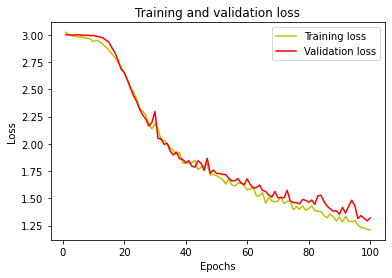

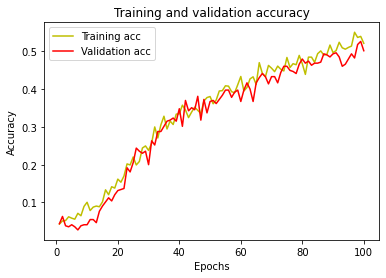

[[12  2  0  0  0  0  0  0  1  1  0  0  0  0  0  0  1  0  0  0]
 [ 0 16  0  0  0  0  1  3  1  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  1  2  0  0  0  0  0  1  3  0  1  0  0  0  2  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  2  6  0  1  0  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  5  0  0  1  0  0  0  8  0]
 [ 0  0  0  0  0  0 11  0  0  1  0  3  0  0  0  0  0  0  0  0]
 [ 2  4  0  1  0  0  0 13  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 6  0  0  0  0  0  0  0 10  1  1  0  0  0  0  0  1  2  0  0]
 [ 1  4  0  0  0  0  0  0  0  6  0  0  0  0  0  3  3  0  0  0]
 [ 0  0  1  0  5  0  4  0  0  0  5  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  2 15  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0  0  0  0  2  2 11  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 14  0  0  0  1  0]
 [ 0  3  0  0  1  0  8  0  0  4  2  1  1  0  0  1  2  0

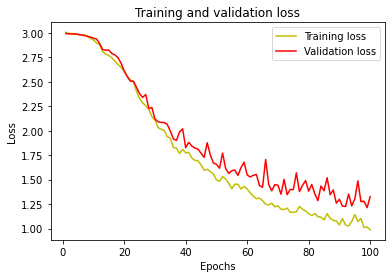

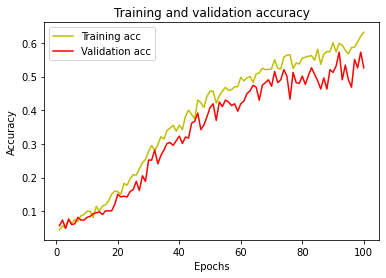

[[ 9  2  0  0  0  0  0  1  0  0  0  0  0  1  0  0  4  0  0  0]
 [ 0 15  0  1  0  0  0  7  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  3  0  1  0  0  0  4  0]
 [ 0  0  0 13  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  6  0  0  0  0  0  0  0  7  0  0  0  0  1  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  1 11  1  0  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  5  0  0  0  0  1  0  0  5  3  0  0]
 [ 0  5  0  0  0  0  0  2  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  2  5  5  0  0  0  2  0  0  3  0]
 [ 0  0  0  0  0  1  5  0  0  0  2  9  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  1  2 10  0  0  1  0  0  2  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  3  0  0  3  0  2  0  0  7  1  0  1  0  0  3  3  0

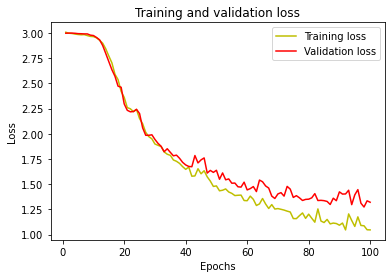

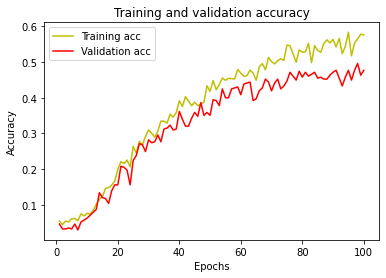

[[10  4  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 15  0  0  0  0  0  0  0  4  0  0  0  0  0  1  2  0  0  0]
 [ 0  0  2  0  0  9  1  0  0  0  0  0  2  0  0  0  0  0  3  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  1  1  0  1  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 10  2  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0 12  0  0  0  1  0  0  0  0  2  0  0  0  0]
 [ 3  1  0  1  0  0  0 15  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0 10  9  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  9  0  0  0  0  0  3  2  0  0  0]
 [ 0  0  0  0  0  1 10  0  0  1  1  0  2  0  0  5  0  0  1  0]
 [ 0  0  0  0  0  1  5  0  0  0  1  7  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 11  0  0  0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  1  0]
 [ 0  3  1  0  0  0  2  0  0 10  1  0  2  0  0  4  0  0

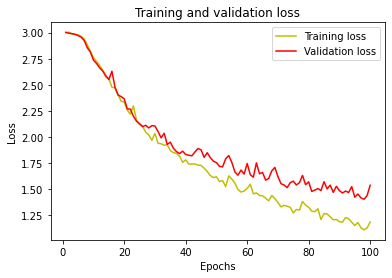

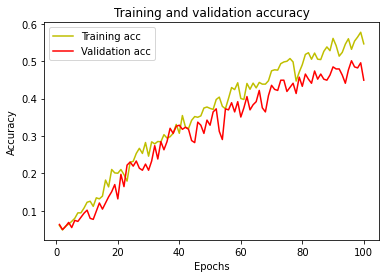

[[10  0  0  0  0  0  0  4  0  1  0  0  0  2  0  0  0  0  0  0]
 [ 8 11  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  3  0  0  1  0  0  0  6  0  0  0  0  0  5  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  3  1  1  0  0  0  7  2  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 11  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  1  0  0  3  0  7  0  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  3  1  0  0  0  5  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  4  7  4  1  0  0  1  0  0  0  2  0  0]
 [ 3  1  0  0  0  0  0  2  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  1  1  2  2  1  4  1  4  0  1  1  1  0  0  0]
 [ 0  0  0  0  0  8  3  0  0  0  0  2  6  0  0  0  0  0  1  0]
 [ 0  0  3  0  0  2  0  0  0  0  1  0  9  0  0  0  0  1  1  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  1  0]
 [ 0  2  0  0  0  0  0  0  2  7  3  0  1  0  0  4  4  0

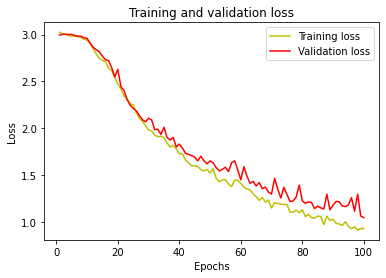

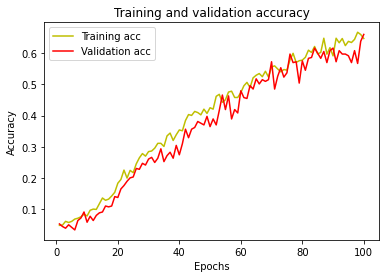

[[11  3  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 1 16  0  0  0  0  0  3  0  3  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  1  3  0  1  0  0  0  1  0]
 [ 0  0  0 12  0  0  0  1  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  1  0  5  0  0  0  0  0  1  0  8  0  0  0  1  0  0  0]
 [ 0  0  1  0  0 10  0  0  0  0  0  2  0  0  1  0  0  0  1  0]
 [ 0  0  0  0  0  0 10  0  0  2  2  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 18  0  1  0  0  0  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 14  0  0  0  0  1  0  0  1  3  0  0]
 [ 0  2  0  0  0  0  0  0  0 13  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  1  0  0  0 10  5  1  0  0  0  2  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  1 15  1  0  0  0  0  0  2  0]
 [ 0  0  1  0  1  0  0  0  0  0  1  0 14  0  0  0  0  0  0  0]
 [ 2  0  0  2  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 12  6  0  0  0  0  0  4  0

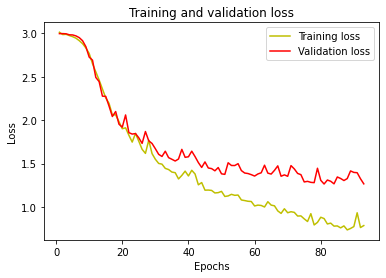

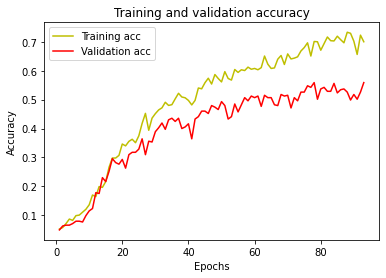

[[12  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2  0  0  0]
 [ 0 13  0  0  0  0  0  3  1  6  0  0  0  0  0  2  0  0  0  0]
 [ 0  0 10  0  1  1  0  0  0  0  0  0  3  0  1  0  0  0  1  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  2  0  0  0 10  0  1  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  1  0  0  0  3  0]
 [ 0  0  0  0  0  0  8  0  0  0  1  4  1  0  0  1  0  0  0  0]
 [ 1  2  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  1  0  0  2  0  0  0  6  0  1  0  0  0  0  0  1  2  0  0]
 [ 0  4  0  0  0  0  0  0  0  8  1  0  0  0  0  4  0  0  0  0]
 [ 0  0  1  0  1  1  3  0  0  2  5  1  5  0  0  2  0  0  0  0]
 [ 0  0  1  0  0  1  2  0  0  0  3 11  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  3  1 12  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 1  1  0  0  0  0  4  1  1  6  2  1  1  0  0  5  0  0

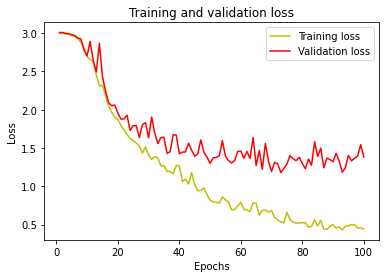

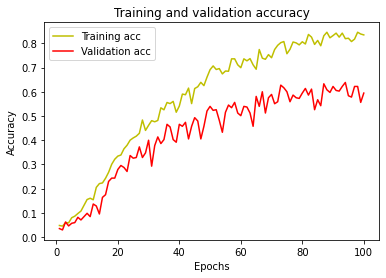

[[13  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  3  0  0  0]
 [ 1 15  0  1  0  0  0  4  2  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  2  0  1  0  0  0  3  0]
 [ 1  0  0 12  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  1  0  3  1  3  0  1  0  0  0  0  1]
 [ 0  0  0  0  0  7  1  0  0  0  0  1  0  0  0  0  0  0  5  1]
 [ 0  0  0  0  0  1  9  0  0  2  0  0  0  0  0  3  0  0  0  0]
 [ 0  2  0  1  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  0  0  0 11  0  0  0  0  1  0  1  2  3  0  0]
 [ 0  1  0  0  0  0  0  2  0 13  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  1  5  0  2  0  2  4  0  0  0  3  0  0  1  1]
 [ 0  0  0  0  0  3  6  0  0  0  5  5  1  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  3  0 10  0  0  0  0  0  2  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 0  3  0  0  0  0  5  0  0  4  1  0  0  0  0  8  2  0

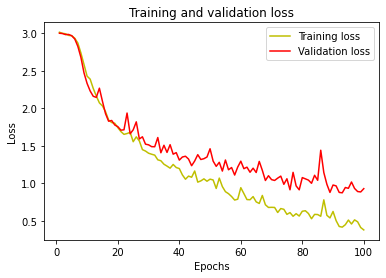

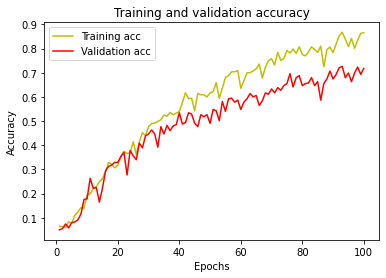

[[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0 16  0  0  0  0  0  1  0  6  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 10  0  0  1  0  0  0  0  0  0  2  0  2  0  0  0  2  0]
 [ 1  0  0  9  0  0  0  1  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  3  0  9  0  0  0  1  0  1  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  2  1  0  0  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0 15  0  1  0  0  0  0  0  1  0  0  0  0]
 [ 3  0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  1  0  0 13  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0 14  1  3  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  4 11  2  0  0  0  0  0  1  0]
 [ 0  0  2  0  0  0  0  0  0  0  2  0 13  0  0  0  0  0  0  0]
 [ 1  0  0  2  0  0  0  1  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  1  2  4  0  0  0  0  7  5  1

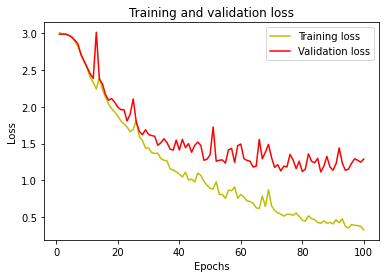

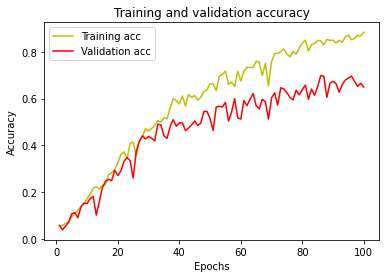

[[14  0  0  0  0  0  0  0  2  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  5  1  1  0  0  0  1  0  0  2  0  0  0]
 [ 0  0 11  0  1  1  0  0  0  0  0  0  3  0  1  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  7  1  1  0  0  1  1  0  3  0  0  1  1  0  0  0]
 [ 0  0  0  0  3 11  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 12  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0 17  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0 15  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  4  1  9  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  2  2  3  0  2  0  3  1  3  0  0  3  2  0  0  0]
 [ 0  0  0  0  3  2  1  0  0  0  2  8  2  0  0  2  0  0  0  0]
 [ 0  0  2  0  1  0  0  0  0  0  0  0 12  0  0  1  1  0  0  0]
 [ 1  0  0  6  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  3  2  0  0  0  0  0 15  1  0

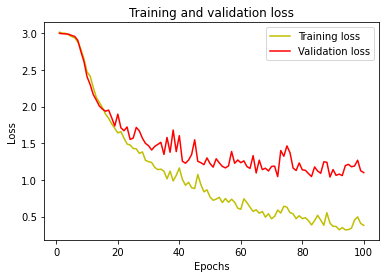

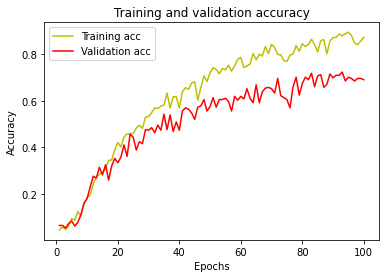

[[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 2 17  0  0  0  0  0  0  1  3  0  0  0  0  0  1  1  0  0  0]
 [ 0  0 12  0  0  1  0  0  0  0  0  0  3  0  0  0  0  0  1  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  2  0 10  0  0  0  0  0  0  0  3  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  1  3  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  1  0  9  0  0  1  3  0  0  0  0  1  0  0  0  0]
 [ 0  6  0  0  0  0  0 13  0  0  0  0  0  1  0  1  0  0  0  0]
 [ 2  1  0  0  0  0  0  1 12  2  0  0  0  0  0  0  1  2  0  0]
 [ 0  2  0  0  0  0  0  0  1 13  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  2  0  0  0 10  3  1  0  0  1  3  0  0  0]
 [ 0  0  2  0  0  2  0  0  0  0  2 14  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  4  0  8  0  0  0  2  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 13  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  3  3  0  0  0  0 15  2  0

In [33]:
window_size = 50
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test1c_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model4(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model5(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

  5%|████▎                                                                          | 68/1247 [00:00<00:01, 604.29it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:32<00:00, 38.09it/s]


[10. 12.  6. 16.  3. 16. 13.  7. 18.  7. 17. 10. 17. 14.  8.  9. 20.  1.
  1. 11.  6.  9. 15. 11. 12.  2.  6. 11. 12.  7.  1. 20.  8. 17. 17. 10.
  7.  4. 10.  2. 16.  9.  1. 19. 18.  5. 15. 17. 11. 20. 14. 18.  2.  2.
 18. 15. 19.  1. 19. 15. 16.  9.  6. 18.  1.  7. 16. 17.  5. 10.  1.  9.
 20.  1. 15.  8.  2. 20. 20.  3.  8. 15.  9. 20.  3. 15. 20.  3. 13.  3.
  9. 14. 16.  4. 19.  3. 11. 13. 10. 19. 11.  8. 13.  5. 17. 18.  1. 15.
 12. 16.  1.  5.  4.  7.  7. 15. 16. 11. 19.  6. 16. 12.  7. 12. 11. 17.
 15. 14. 16.  6. 13. 18. 17. 13.  9. 19.  9. 16.  9. 18.  3. 16.  8. 20.
 20. 14. 16. 14. 18.  2.  3.  7. 11.  5.  6.  4.  1.  7.  5. 16.  5. 15.
  8.  5. 15.  6. 12. 10. 12. 17.  8. 10. 10. 17. 18. 13. 18. 19. 10. 20.
 12.  7. 17. 18.  8.  7. 20. 20.  3.  1.  4. 10. 14. 10.  5.  1.  9. 20.
 19. 10. 18. 14. 14. 12. 10.  5. 10. 17.  2. 11.  1.  4.  2. 11. 15. 14.
  2. 18. 17. 19. 19.  2.  9. 19.  4. 18. 15.  5. 11. 16.  8.  2. 17.  1.
 12.  5.  6. 20. 10.  4. 16. 20.  2. 11.  7. 16. 19

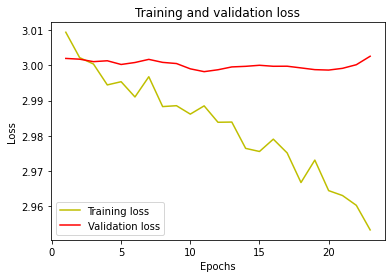

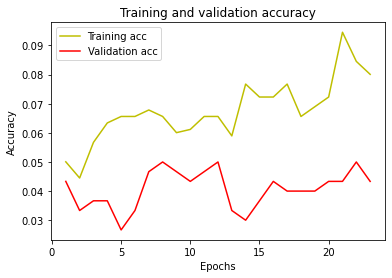

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0 0 0 0 4 0 0 0 0 0 2 0 0 0 0 0 3 0 1 2]
 [0 0 0 0 4 0 3 0 0 0 2 1 0 0 0 0 3 0 3 2]
 [0 0 0 0 2 0 3 0 0 0 0 1 0 0 0 0 1 0 3 2]
 [0 0 1 0 3 0 2 0 0 0 6 0 0 0 0 0 2 0 7 1]
 [0 0 0 0 1 0 4 0 0 0 2 0 0 0 0 0 1 0 3 2]
 [0 0 1 0 2 0 4 0 0 0 2 0 0 0 0 0 1 0 4 5]
 [0 0 0 0 2 0 3 0 0 0 2 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 4 0 2 0 0 0 4 0 1 0 0 0 0 0 2 3]
 [0 0 0 0 2 0 3 0 0 0 4 1 0 0 0 0 3 0 3 2]
 [1 0 0 0 4 0 1 0 0 0 1 0 0 0 0 0 0 0 3 4]
 [0 0 0 0 1 0 3 0 0 0 1 0 0 0 0 0 1 0 3 1]
 [0 0 0 0 6 0 2 0 0 0 3 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 2 0 4 0 0 0 2 1 0 0 0 0 3 0 2 1]
 [0 0 0 0 3 0 2 0 0 0 7 0 0 0 0 0 2 0 5 3]
 [0 0 0 0 4 0 2 0 0 0 1 0 0 0 0 0 0 0 3 5]
 [0 0 0 0 3 0 2 0 0 0 3 2 0 0 0 0 1 0 3 1]
 [0 0 1 0 0 0 2 0 0 0 2 0 0 0 0 0 3 0 4 4]
 [0 0 0 0 6 0 3 0 0 0 1 1 0 0 0 0 0 0 3 4]
 [0 0 0 0 0 0 4 0 0 0 1 1 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 3 0 0 0 2 2 0 0 0 0 0 0 2 4]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0

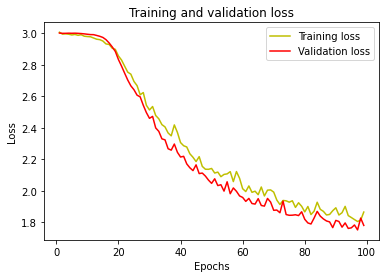

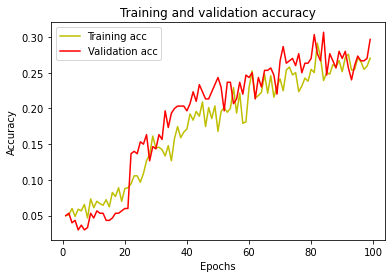

[[ 0  2  0  1  0  0  0  8  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  3  0  1  0  0  0  8  0  5  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  1  2  0  2  0  0  0  3  0]
 [ 0  0  0  5  0  0  0  1  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  8  0  0  0  0  1  1  0  0  1  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  4  0]
 [ 0  0  2  0  0  0  3  0  0  0  2  1  1  0  0  1  0  0  0  0]
 [ 0  0  0  2  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  1  0  0  4  0  0  0  0  0  8  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  6  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  3  0  0  0  4  0  0  0  1  0  0  0  0  2  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  2  0  0  1  0  0  0  2  0]
 [ 0  0  5  0  0  0  5  0  0  0  1  1  2  0  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 0  1  1  0  0  0  7  0  0  1  2  0  0  0  0  3  0  0

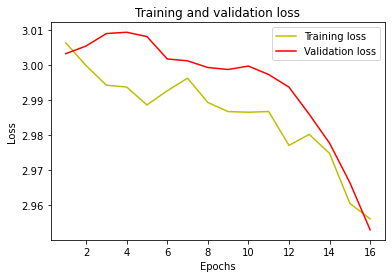

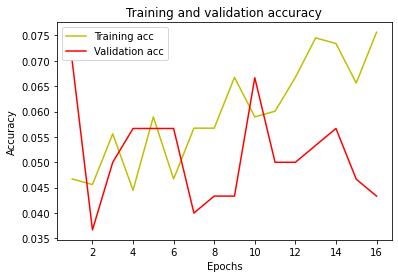

[[ 0  0  0  0  0  0  0  0  0  0  1  5  0  0  0  0  0  2  4  0]
 [ 2  0  0  0  0  0  0  0  0  0  1  4  0  0  0  2  0  0  3  6]
 [ 1  0  0  0  0  0  1  0  0  0  3  3  0  0  0  1  0  0  1  2]
 [ 4  0  0  0  0  0  0  0  0  0  1  4  0  0  0  1  0  0 10  2]
 [ 3  0  0  0  0  0  0  0  0  0  0  2  0  0  0  2  0  0  1  5]
 [ 5  0  0  0  0  0  1  0  0  0  3  0  0  0  0  0  0  0  4  6]
 [ 1  0  0  0  0  0  0  0  0  0  3  3  0  0  0  0  0  0  1  2]
 [ 4  0  0  0  0  0  0  0  0  0  0  6  0  0  0  1  0  0  2  3]
 [ 3  0  0  0  0  0  0  0  0  0  2  6  0  0  0  0  0  0  2  5]
 [ 0  0  0  0  0  0  0  0  0  0  2  5  0  0  0  0  0  0  1  6]
 [ 3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  1  4]
 [ 1  0  0  0  0  0  0  0  0  0  1  4  0  0  0  0  0  1  4  3]
 [ 1  0  0  0  0  0  0  0  0  0  1  3  0  0  0  1  0  0  2  7]
 [ 6  0  0  0  0  0  2  0  0  0  1  4  0  0  0  0  0  0  6  3]
 [ 2  0  0  0  0  0  0  0  0  0  0  4  0  0  0  2  0  0  1  6]
 [ 5  0  0  0  0  0  0  0  0  0  1  4  0  0  0  1  0  0

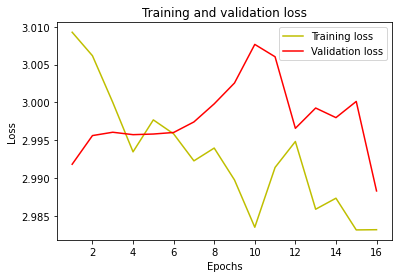

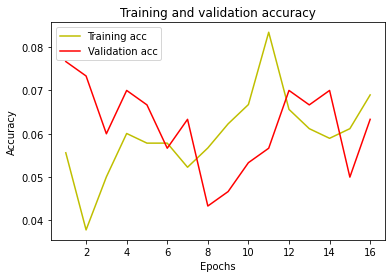

[[ 0  0  0  0  0  0  0  0  7  0  0  2  0  0  2  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  7  0  0  1  1  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  3  0  0  3  0  0  0  2  1]
 [ 0  0  0  0  0  0  0  0  7  0  0  2  0  0  6  1  0  0  6  0]
 [ 0  0  0  0  0  0  0  1  2  0  0  4  0  0  1  0  0  0  3  2]
 [ 0  0  0  0  0  0  0  0  5  0  0  6  0  0  0  1  0  0  7  0]
 [ 0  0  0  0  0  0  1  0  1  0  0  3  0  0  2  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  4  0  0  2  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  4  0  0  4  0  0  0  5  0]
 [ 0  0  0  0  0  0  1  0  6  0  0  1  0  0  1  0  0  0  4  1]
 [ 0  0  0  0  0  0  0  0  3  0  0  3  0  0  2  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  4  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  5  0  0  5  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  4  0  0  9  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  6  0  0  2  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  3  0  0  5  0  0  0

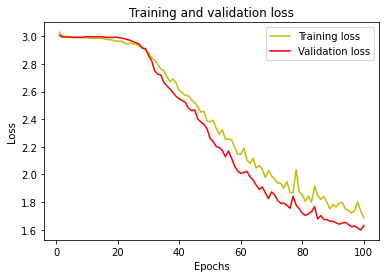

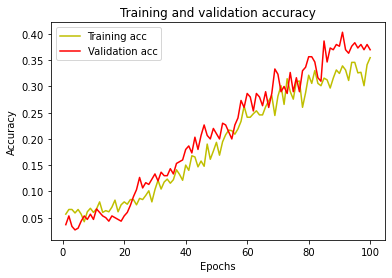

[[ 8  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 4  5  0  1  0  0  2  3  0  1  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  1  0  1  0  3  0  0  0  4  0]
 [ 0  0  0  7  0  0  0  1  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  2  3  5  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  1  0 13  0  0  0  4  0]
 [ 0  0  0  0  0  0  6  0  0  0  0  2  2  0  0  0  0  0  0  0]
 [ 2  1  0  9  0  0  0  3  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 1  3  0  0  0  0  2  0  0  3  1  1  1  0  0  0  5  1  0  0]
 [ 2  2  0  0  0  0  2  0  0  4  1  0  1  0  0  0  2  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  2  4  0  2  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  6  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  3  9  0  0  0  0  0  1  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  1  0]
 [ 0  1  0  0  0  0  2  0  0  2  1  0  8  0  0  0  1  0

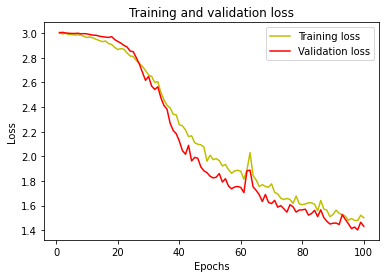

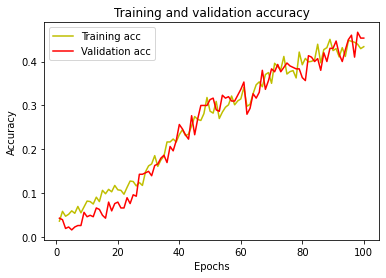

[[ 6  1  0  0  0  0  0  2  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 4  8  0  0  0  0  0  0  0  5  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  5  3  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  2  0  0  0  2  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  5  0  0  5  0  0  0  7  0]
 [ 0  0  0  0  3  0  2  0  0  0  1  3  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  1  0  0  0  5  0  0  0  0  0  0]
 [ 1  1  0  0  1  0  0  0  6  7  0  0  0  0  0  0  1  1  0  0]
 [ 0  3  0  0  0  0  0  0  1 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  1  0  1  2  0  2  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0 10  2  0  0  0  0  0  1  0]
 [ 0  0  0  0  8  0  0  0  0  0  1  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  4  0  2  0  0  2  4  0  1  0  0  2  0  0

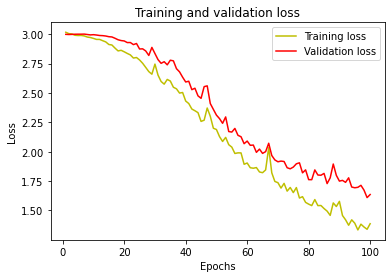

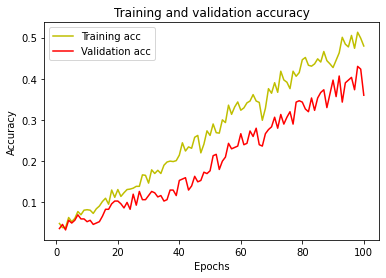

[[ 7  1  0  0  0  0  0  1  1  0  0  0  0  1  0  0  1  0  0  0]
 [ 5  1  0  0  0  0  0  1  2  3  0  0  0  1  0  1  4  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  5  0  5  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  2  1  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  1  0  0  1  5  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  3  0  0  0 12  3]
 [ 0  0  0  0  1  0  2  0  0  0  0  4  2  0  0  0  1  0  0  0]
 [ 1  1  0  3  0  0  0  7  0  1  0  0  0  3  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  2  4  1  0  0  0  0  1  6  3  0  0]
 [ 3  1  0  0  0  0  0  1  2  2  0  0  0  0  0  1  4  0  0  0]
 [ 0  1  0  0  0  1  1  0  0  0  2  3  0  0  0  1  1  0  0  0]
 [ 0  0  2  0  0  2  0  0  0  0  0  6  1  0  2  0  0  0  1  0]
 [ 0  0  0  0  1  1  0  0  0  0  1  4  7  0  1  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0 10  0  0  0  4  0]
 [ 1  0  0  0  1  0  0  0  0  0  3  1  2  0  0  4  2  1

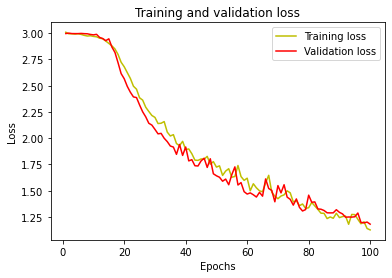

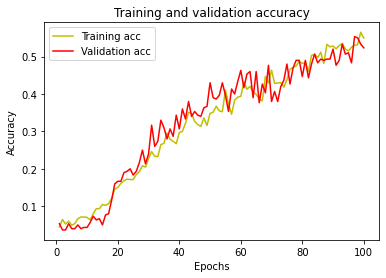

[[11  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  4  0  2  0  0  0  1  0  0  2  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  2  1]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  1  0  0  0  4  1  1  0  0  2  0  0  0  0]
 [ 0  0  1  0  0  6  0  0  0  0  0  1  1  0  0  0  0  0 10  0]
 [ 0  0  0  0  2  0  7  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 13  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 7  0  0  0  2  0  0  0  4  2  0  0  0  0  0  2  0  1  0  0]
 [ 0  1  0  0  0  0  0  2  0 10  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  1  0  0  0  0  0  1  0  6  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  0  6  1  0  0  0  0  0  1  0]
 [ 0  0  1  0  3  0  1  0  0  0  6  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  3  0]
 [ 1  0  0  0  0  0  0  0  0  3  7  0  0  0  0  4  0  0

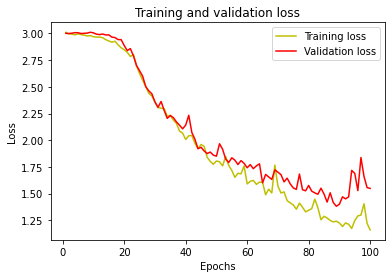

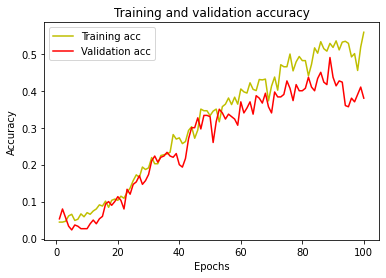

[[ 7  0  0  1  0  0  0  3  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 6  6  0  0  0  0  0  3  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  1  7  1  0  0  0  0  0  1  0]
 [ 1  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  5  0  1  0  0  1  0  0  2  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  3  2  0  0  0  0  5  0  0  1  0  0  0  8  0]
 [ 0  0  0  0  0  0  3  0  0  0  5  2  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 3 10  0  1  1  0  0  0  2  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  4  0  2  0  0  0  0  0  1  6  0  0  0]
 [ 0  0  0  0  1  0  3  0  0  0  2  0  0  0  0  1  3  0  0  0]
 [ 0  0  2  0  1  0  5  0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  4  0  0  0  0  0  1  2  6  0  0  0  0  0  0  0]
 [ 1  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0  0  9  0  0  0  2  0]
 [ 1  1  0  0  5  0  0  2  0  3  0  0  0  0  0  2  1  0

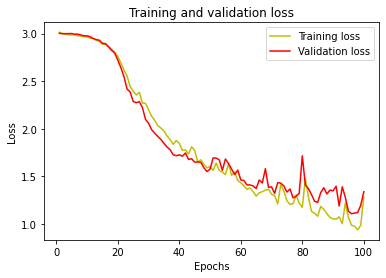

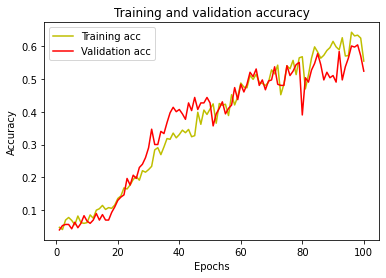

[[ 5  5  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 2 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  3  0  0  0  0  0  0  3  0  1  0  0  0  3  0]
 [ 0  0  0 14  0  0  0  4  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  1  0  0  0  1  0  2  0  0  4  0  0  0  1]
 [ 0  0  0  0  0  1  0  0  0  0  0  2  0  0  4  0  0  0 12  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  0  0  0  0  1  1  3  1  0  0  0  1  0  3  2  3  0  0]
 [ 0  9  0  0  0  0  0  0  0  2  0  0  0  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  1  4  1  0  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  4  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  2  0  0  0  9  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  9  0  0  0  3  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 0  1  0  0  0  0  3  1  0  3  0  0  0  0  0  7  0  0

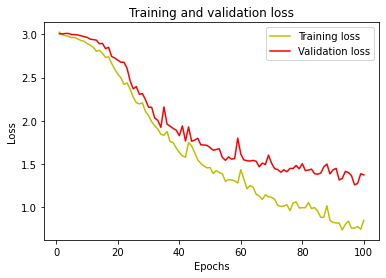

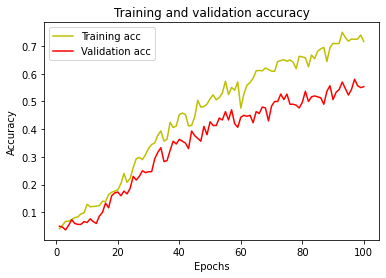

[[ 9  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 1  8  0  0  0  0  0  0  0  3  0  0  0  1  0  0  5  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0 11  0  0  0  1  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  2  0  6  0  0  0  0  0  2  0  3  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  8  0  0  0  0  0  0  0  0  3  0  0  0  3  0]
 [ 0  0  0  0  0  0  3  0  0  0  4  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  3  0  0  0 10  0  0  0  1  0  0  0  1  2  0  0]
 [ 0  2  0  0  0  0  0  0  1  7  0  0  1  0  0  1  2  0  0  0]
 [ 0  0  1  0  2  0  0  0  0  0  3  0  4  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  1  3  0  0  0  0  6  0  0  0  0  0  0  2  0]
 [ 0  0  1  0  9  0  0  0  0  0  0  0  4  0  0  0  0  0  1  0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  2  0]
 [ 0  0  1  0  1  0  2  0  0  1  2  0  3  0  0  2  3  0

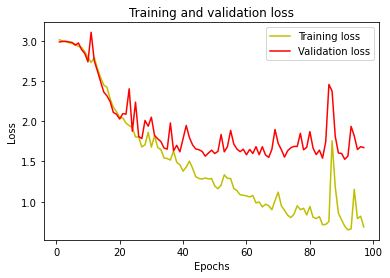

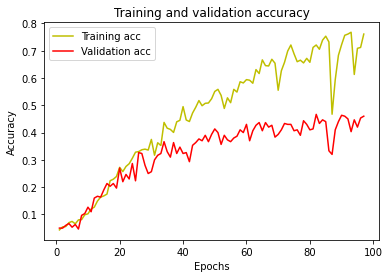

[[ 9  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 1  9  0  0  0  0  0  1  1  1  0  0  0  1  0  1  3  0  0  0]
 [ 0  0  6  0  3  0  0  0  0  0  0  1  1  0  0  0  0  0  1  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  7  0  1  0  0  1  3  0  0  0]
 [ 0  0  4  0  2  1  1  0  0  0  0  1  4  0  2  0  0  0  4  0]
 [ 0  0  0  0  0  0  3  0  0  0  3  2  1  0  0  0  1  0  0  0]
 [ 2  1  0  3  0  0  0  9  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  6  0  0  1  0  1  0  2  1  0  0  0  0  0  2  3  1  0  0]
 [ 0  3  0  0  0  0  0  0  0  5  0  0  0  0  0  2  4  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  4  0  1  0  0  2  2  0  0  0]
 [ 0  0  1  0  1  0  4  0  0  0  4  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  1  0  0  0  4  1  3  0  0  1  0  0  0  0]
 [ 1  0  0  7  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 13  0  0  0  1  0]
 [ 0  2  0  0  0  0  0  0  1  0  5  0  2  0  0  4  1  0

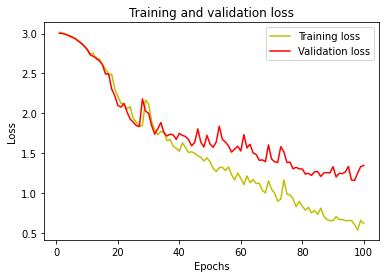

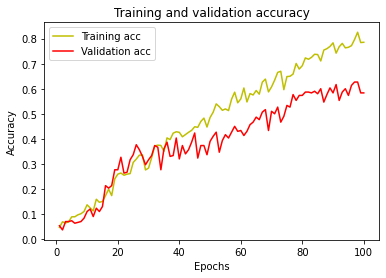

[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0 12  0  0  0  0  0  1  0  2  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  5  0  2  0  1  0  0  0  0  2  1  0  0  0  0  0  1  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  1  0  6  0  4  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  4  1  0  0  0  0  2  0  0  2  0  0  0  8  0]
 [ 0  0  0  0  1  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  0  0  1  0  2  0  3  2  0  0  0  0  0  1  6  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  8  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  3  0  0  0  1  1  1  0  0  2  1  0  0  0]
 [ 0  0  0  0  0  1  6  0  0  0  0  4  1  0  0  0  0  0  2  0]
 [ 0  0  1  0  7  0  2  0  0  1  0  0  4  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0]
 [ 0  0  2  0  0  2  0  0  0  0  0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  4  0  2  0  0  0  3  0  0  0  0  4  2  0

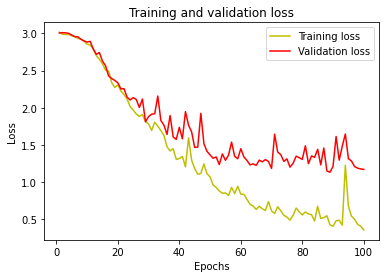

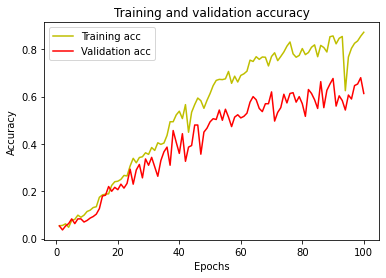

[[ 8  0  0  2  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1 14  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  2  0  0  0  0  1  0  0  0  0  1  0  0  3  0]
 [ 0  0  0 16  0  0  0  0  1  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  5  0  0  1  1  0  0  0]
 [ 0  0  0  0  0 15  2  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  1  6  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  9  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 2  1  0  0  1  0  0  0 10  1  0  0  0  0  0  1  2  0  0  0]
 [ 3  1  0  0  0  0  1  0  1  6  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  1  0  1  0  1  0  5  0  1  0  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  0  0  0  9  2  0  1  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  1 10  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 13  0  0  0  0  0]
 [ 1  2  0  0  1  0  0  0  1  1  0  0  1  0  0  8  0  0

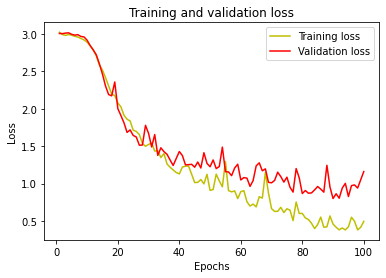

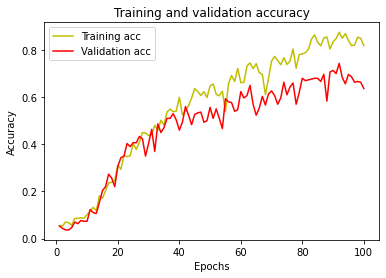

[[ 9  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0]
 [ 0 11  0  0  0  0  0  0  1  4  0  0  0  1  0  0  1  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  1  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  1  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  5  0  0  0 11  0]
 [ 0  0  0  0  0  0  3  0  0  0  1  6  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0 13  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  1  0  0  1  0  0  0  0  4  1  0  0  0  0  0  7  0  0  0]
 [ 0  0  1  0  3  0  0  0  0  0  1  1  4  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  8  1  0  0  0  0  0  4  0]
 [ 0  0  2  0  3  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  2  0  1  0  0  5  1  1

In [34]:
window_size = 60
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test1c_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model4(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model5(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

[[1 ' LMenu' ' Tab' ... 187 312 125]
 [1 ' Tab' ' LMenu' ... 172 1139 967]
 [1 ' LMenu' ' Tab' ... 124 218 94]
 ...
 [54 ' A' ' Space' ... 62 234 172]
 [54 ' Space' ' B' ... 78 421 343]
 [54 ' B' ' O' ... 78 296 218]]
[[1 'lmenu' 'tab' ... 187 312 125]
 [1 'tab' 'lmenu' ... 172 1139 967]
 [1 'lmenu' 'tab' ... 124 218 94]
 ...
 [54 'a' 'space' ... 62 234 172]
 [54 'space' 'b' ... 78 421 343]
 [54 'b' 'o' ... 78 296 218]]


  1%|▉                                                                              | 99/7988 [00:00<00:08, 885.67it/s]

(79901, 138)


100%|██████████████████████████████████████████████████████████████████████████████| 7988/7988 [12:13<00:00, 10.89it/s]


[ 5. 35. 11. ... 27. 15. 19.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
inputShape: (30, 138)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 29, 32)            8864      
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 28, 32)            2080      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 14, 32)            0         
_________________________________________________________________
gru_54 (GRU)                 (None, 14, 32)            6336      
___________________________________________

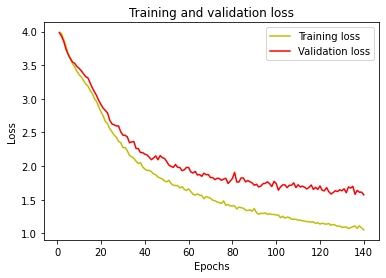

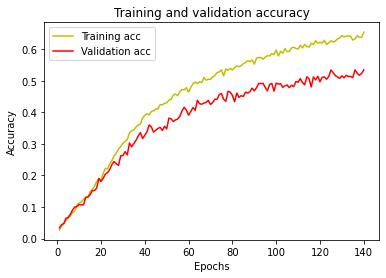

[[14  1  0 ...  3  0  0]
 [ 1 20  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 1  0  0 ... 18  0  0]
 [ 0  4  0 ...  0 13  0]
 [ 0  0  0 ...  0  1 19]]
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        32
           1       0.45      0.56      0.50        36
           2       0.47      0.67      0.55        27
           3       0.75      0.70      0.72        43
           4       0.52      0.59      0.55        29
           5       0.36      0.47      0.41        34
           6       0.47      0.38      0.42        42
           7       0.89      0.59      0.71        41
           8       0.40      0.49      0.44        37
           9       0.44      0.44      0.44        36
          10       0.61      0.61      0.61        67
          11       0.55      0.49      0.52        35
          12       0.44      0.46      0.45        35
          13       0.69      0.80      0.74        30
          14       0.74      0.70

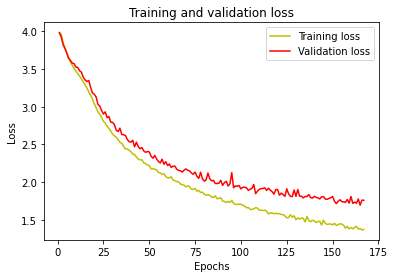

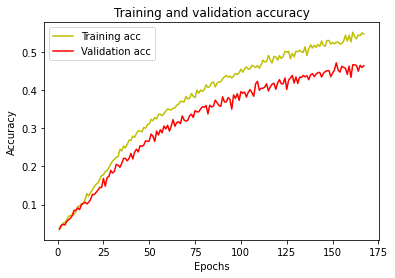

[[14  0  0 ...  2  0  0]
 [ 1 13  0 ...  0  1  0]
 [ 0  0 22 ...  0  0  0]
 ...
 [ 3  0  0 ... 11  0  0]
 [ 0  3  0 ...  0 13  0]
 [ 0  2  0 ...  0  0 17]]
              precision    recall  f1-score   support

           0       0.30      0.44      0.36        32
           1       0.23      0.36      0.28        36
           2       0.49      0.81      0.61        27
           3       0.74      0.53      0.62        43
           4       0.50      0.59      0.54        29
           5       0.38      0.38      0.38        34
           6       0.39      0.76      0.52        42
           7       0.75      0.51      0.61        41
           8       0.20      0.08      0.12        37
           9       0.30      0.47      0.37        36
          10       0.45      0.61      0.52        67
          11       0.31      0.63      0.42        35
          12       0.39      0.49      0.43        35
          13       0.59      0.77      0.67        30
          14       0.75      0.64

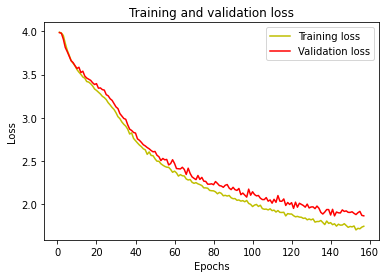

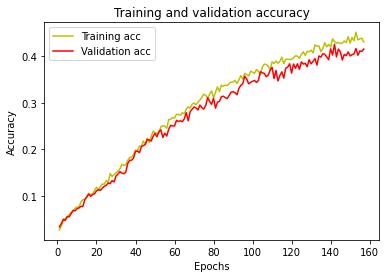

[[17  0  0 ...  0  0  0]
 [ 1  9  0 ...  0  1  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 5  0  0 ...  3  0  0]
 [ 1  3  0 ...  0 16  0]
 [ 0  2  1 ...  0  0 13]]
              precision    recall  f1-score   support

           0       0.39      0.53      0.45        32
           1       0.17      0.25      0.20        36
           2       0.32      0.26      0.29        27
           3       0.63      0.44      0.52        43
           4       0.23      0.62      0.33        29
           5       0.40      0.24      0.30        34
           6       0.26      0.19      0.22        42
           7       0.53      0.63      0.58        41
           8       0.48      0.35      0.41        37
           9       0.19      0.14      0.16        36
          10       0.45      0.52      0.48        67
          11       0.31      0.51      0.38        35
          12       0.00      0.00      0.00        35
          13       0.38      0.87      0.53        30
          14       0.53      0.82

KeyboardInterrupt: 

In [27]:
# ZACZYNAM TUTAJ - PORÓWNANIE RÓŻNYCH ARCHITEKTUR
def load_data(file, nrows = None):
    path = "{}/{}".format("new_data_different_texts50", file)
    data = pd.read_csv(path, sep=",", header = None, nrows = nrows) 
#     return np.array(data)
    return pd.DataFrame(data)

files = os.listdir("{}".format("new_data_different_texts50"))
frames = []
number_of_rows = 1500

for file in files: 
    data = load_data(file, number_of_rows)
    frames.append(data)
    
data = pd.concat(frames)
data = np.array(data)
data = data[:, :-1]

print(data)
keys = data[:, 1:3]
for row in range(keys.shape[0]):
    for column in range(keys.shape[1]):
        data[row, column + 1] = data[row, column + 1].lower().replace(" ", "")
        
print(data)

enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((data[:,1], data[:,2]), axis=0).reshape(-1, 1))

first_column = enc.transform(data[:,1].reshape(-1, 1)).toarray()
second_column = enc.transform(data[:,2].reshape(-1, 1)).toarray()

# letters encoding - order: A1A2 B1B2 etc.
encoded_letters = [[]]

for i in range(0, first_column.shape[1]):
    if(i == 0):
      encoded_letters = np.column_stack((first_column[:, i], second_column[:, i]))
    else:
      encoded_letters = np.column_stack((encoded_letters, first_column[:, i], second_column[:, i]))
      
# normalization - z score
std_scaler = StandardScaler()
encoded_letters_scaled = std_scaler.fit_transform(encoded_letters) 
time_values_scaled = std_scaler.fit_transform(data[:, 3:])

prepared_data = np.column_stack((data[:, 0], encoded_letters_scaled, time_values_scaled))

(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, 30, random_state =5 )

dropouts = [0.2, 0.3, 0.4, 0.5]
for dropout in dropouts: 
    model = build_model(32, 2, 32, dropout) 
    train_model(model, 'Adam', 32, 32,4, 0, 60)
    print_metrics()

In [25]:
# CNN - GRU
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 54
#     inputShape=(None,trainSamplesX.shape[1],trainSamplesX.shape[2]) 

    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model


inputShape: (30, 138)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 29, 16)            4432      
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 28, 16)            528       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 14, 16)            0         
_________________________________________________________________
gru_34 (GRU)                 (None, 14, 16)            1632      
_________________________________________________________________
gru_35 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dropout_40 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_40 (Dense)             (N

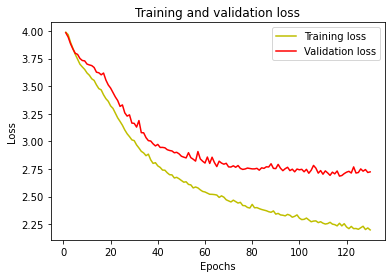

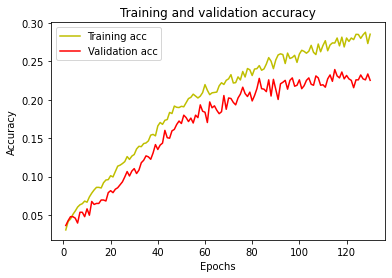

[[4 4 0 ... 1 0 0]
 [0 6 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 1]]
              precision    recall  f1-score   support

           0       0.09      0.14      0.11        29
           1       0.16      0.23      0.19        26
           2       0.00      0.00      0.00        40
           3       0.70      0.36      0.48        44
           4       0.27      0.16      0.20        19
           5       0.13      0.35      0.19        17
           6       0.17      0.19      0.18        31
           7       0.20      0.15      0.17        34
           8       0.41      0.42      0.42        40
           9       0.17      0.22      0.20        36
          10       0.27      0.43      0.33        56
          11       0.13      0.11      0.12        27
          12       0.25      0.44      0.32        34
          13       0.14      0.53      0.22        19
          14       0.45      0.68      0.54        38
          15   

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 29, 32)            8864      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 28, 32)            2080      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
gru_36 (GRU)                 (None, 14, 32)            6336      
_________________________________________________________________
gru_37 (GRU)                 (None, 32)                6336      
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)              

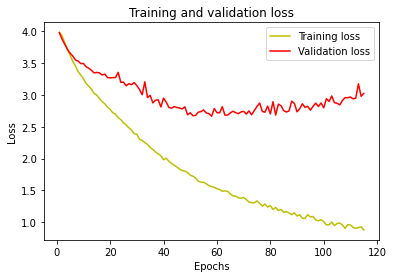

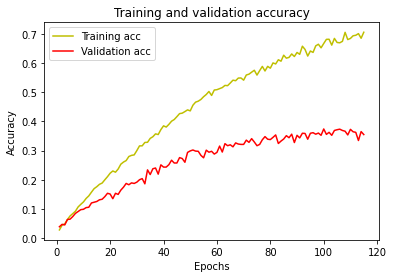

[[ 8  0  0 ...  3  0  0]
 [ 0  9  0 ...  0  1  0]
 [ 0  0 10 ...  0  0  4]
 ...
 [ 2  0  0 ...  6  0  0]
 [ 0  2  0 ...  0  4  0]
 [ 0  0  0 ...  0  0 11]]
              precision    recall  f1-score   support

           0       0.38      0.28      0.32        29
           1       0.21      0.35      0.26        26
           2       0.53      0.25      0.34        40
           3       0.85      0.39      0.53        44
           4       0.36      0.42      0.39        19
           5       0.24      0.47      0.31        17
           6       0.42      0.42      0.42        31
           7       0.58      0.41      0.48        34
           8       0.44      0.17      0.25        40
           9       0.33      0.31      0.32        36
          10       0.43      0.54      0.48        56
          11       0.24      0.26      0.25        27
          12       0.28      0.15      0.19        34
          13       0.59      0.53      0.56        19
          14       0.52      0.79

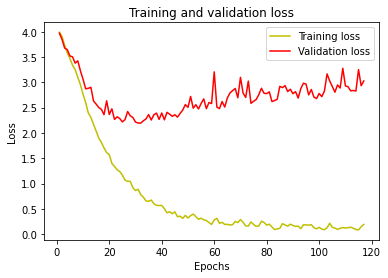

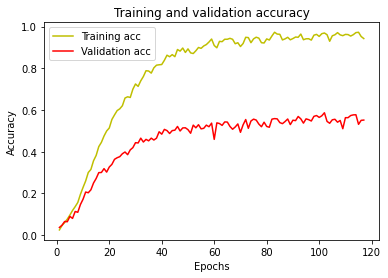

[[17  0  0 ...  1  1  0]
 [ 0  9  0 ...  0  0  3]
 [ 0  0 26 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  1  0 ...  0 10  0]
 [ 0  0  1 ...  0  0 12]]
              precision    recall  f1-score   support

           0       0.57      0.59      0.58        29
           1       0.38      0.35      0.36        26
           2       0.52      0.65      0.58        40
           3       0.91      0.45      0.61        44
           4       0.62      0.68      0.65        19
           5       0.40      0.71      0.51        17
           6       0.40      0.55      0.46        31
           7       0.70      0.62      0.66        34
           8       0.78      0.53      0.63        40
           9       0.56      0.56      0.56        36
          10       0.63      0.61      0.62        56
          11       0.45      0.33      0.38        27
          12       0.61      0.56      0.58        34
          13       0.58      0.79      0.67        19
          14       0.67      0.76

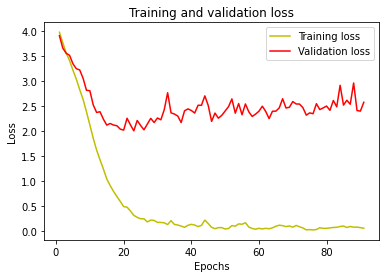

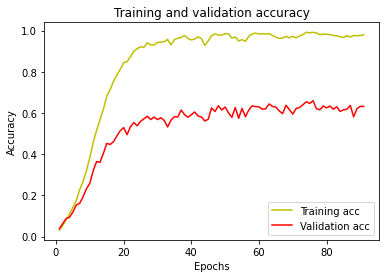

[[22  0  0 ...  1  0  0]
 [ 0 16  0 ...  0  0  1]
 [ 0  0 26 ...  0  0  1]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  1 ...  0  0 13]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        29
           1       0.44      0.62      0.52        26
           2       0.67      0.65      0.66        40
           3       1.00      0.48      0.65        44
           4       0.65      0.79      0.71        19
           5       0.65      0.65      0.65        17
           6       0.52      0.71      0.60        31
           7       0.70      0.82      0.76        34
           8       0.62      0.62      0.62        40
           9       0.80      0.67      0.73        36
          10       0.91      0.57      0.70        56
          11       0.61      0.52      0.56        27
          12       0.88      0.65      0.75        34
          13       0.50      0.89      0.64        19
          14       0.81      0.79

KeyboardInterrupt: 

In [22]:


model = build_model(16, 2, 16, 0.4) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(32, 2, 32, 0.4) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(64, 2, 64, 0.4) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(128, 2, 128, 0.4) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(256, 2, 256, 0.4) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

inputShape: (40, 138)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 39, 16)            4432      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 38, 16)            528       
_________________________________________________________________
dropout_16 (Dropout)         (None, 38, 16)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 19, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_17 (Dropout)         (No

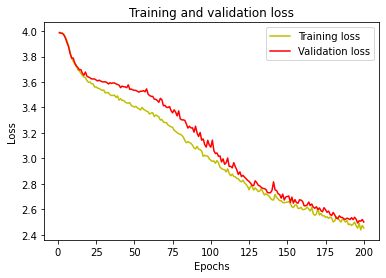

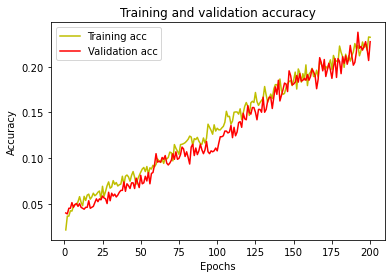

[[7 0 0 ... 2 0 0]
 [1 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
              precision    recall  f1-score   support

           0       0.26      0.28      0.27        25
           1       0.06      0.07      0.07        14
           2       0.00      0.00      0.00        25
           3       0.36      0.46      0.41        26
           4       0.36      0.40      0.38        20
           5       0.11      0.10      0.10        21
           6       0.20      0.09      0.13        22
           7       0.40      0.10      0.15        21
           8       0.10      0.08      0.09        12
           9       0.14      0.25      0.18        16
          10       0.23      0.50      0.31        38
          11       0.11      0.27      0.16        15
          12       0.00      0.00      0.00        17
          13       0.19      0.50      0.27        24
          14       0.33      0.42      0.37        19
          15   

KeyboardInterrupt: 

In [13]:
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 54
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(gru_neurons, return_sequences=True))
    model.add(LSTM(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

# trainSamples = trainSamplesX.reshape((trainSamplesX.shape[0],1, trainSamplesX.shape[1], trainSamplesX.shape[2]))
# testSamples = testSamplesX.reshape((testSamplesX.shape[0],1, testSamplesX.shape[1], testSamplesX.shape[2])) 

model = build_model(16, 2, 16, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()


model = build_model(32, 2, 32, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(64, 2, 64, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(128, 2, 128, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(256, 2, 256, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

In [ ]:
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 54
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

model = build_model(16, 2, 16, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()


model = build_model(32, 2, 32, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(64, 2, 64, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(128, 2, 128, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(256, 2, 256, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

In [ ]:
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 54
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()    
    model.add(LSTM(gru_neurons, return_sequences=True, input_shape = inputShape))
    model.add(LSTM(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

model = build_model(16, 2, 16, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()


model = build_model(32, 2, 32, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(64, 2, 64, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(128, 2, 128, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(256, 2, 256, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

In [ ]:
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 54
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()    
    model.add(GRU(gru_neurons, return_sequences=True, input_shape = inputShape))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

model = build_model(16, 2, 16, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()


model = build_model(32, 2, 32, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(64, 2, 64, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(128, 2, 128, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()

model = build_model(256, 2, 256, 0.5) 
train_model(model, 'Adam', 32, 32,4, 0, 60)
print_metrics()